In [1]:
!pip install fasttext
!pip install nltk
# !pip install memory_profiler
# !pip install -U mkl
# !pip install -U nump
# !pip install --upgrade tensorflow
# !pip install --upgrade keras

  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3143614 sha256=a6d830fe6f0938b84c0dc8002d7fa9d25e6694f78abcc441eac0a338cbd12d38
  Stored in directory: /root/.cache/pip/wheels/c3/5c/d0/4a725c6ee7df3267d818d3bc9d89bb173b94832f2b9eca6368
Successfully built fasttext
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.5 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 749 kB 8.9 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 7.2 MB/s  eta 0:00:01
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


# Экспериментальная часть

In [9]:
import numpy as np
import pandas as pd
# import nltk
import string
import datetime
import matplotlib.pyplot as plt
import os
import gc
import fasttext.util
import random
import joblib
from itertools import product

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

from scipy.spatial.distance import jensenshannon
import scipy.io as sio
from scipy.special import rel_entr, kl_div
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import jensenshannon
from scipy.special import rel_entr

# from skmultiflow.drift_detection import DDM, PageHinkley, ADWIN
# from skmultiflow.data import Conc>eptDriftStream

from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Embedding, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf

from sys import getsizeof
from sys import getrefcount

In [10]:
# fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')
samples_number = 7

### Подготовка данных

In [11]:
# # porter_stemmer = nltk.stem.PorterStemmer()
# # tok = CountVectorizer().build_tokenizer()
# df_all = pd.read_csv('Electronics_5.csv')
# df_all.reviewTime = pd.to_datetime(df_all.reviewTime, format="%m %d, %Y")
# df_all = df_all.sort_values(by = 'reviewTime').reset_index(drop = True)
# df_all["bin_label"] = df_all.overall > 3
# df_all['label'] = df_all.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
# df_all["words"] = list(map(lambda elem: (" ").join(map(lambda s: (porter_stemmer.stem(s)), elem)).lower().translate(str.maketrans('', '', string.punctuation)), map(lambda wrds: tok(wrds), df_all.reviewText.apply(lambda x: np.str_(x)))))

In [12]:
# df_by_years = {}
# for year in df_all.reviewTime.dt.year.unique().tolist():
#     df_by_years[year] = df_all[df_all.reviewTime.dt.year == year].reset_index(drop = True)
#     print(year, len(df_by_years[year]))
#     print(df_by_years[year].bin_label.value_counts(), '\n')

In [13]:
# skf = StratifiedKFold(n_splits=samples_number)
# for year in range(2007, 2015):
#     data_tmp = df_by_years[year].sample(35000)
#     data_list = []
#     index = 0
#     for train_index, test_index in skf.split(data_tmp.words, data_tmp.label):
#         data = data_tmp.iloc[test_index]
#         data[['words', 'label']].to_csv('data/{0}_{1}.csv'.format(year, index))
#         index += 1
#     print(year)
# del df_by_years
# del df_all
# del porter_stemmer
# del tok
# gc.collect()

### Вычисления

In [14]:
df_accuracy = pd.DataFrame(np.zeros([2015-2007, (2015-2007)*samples_number]), index=range(2007, 2015), columns=pd.MultiIndex.from_product([range(2007, 2015), range(samples_number)]))

df_tvd_lstm = df_accuracy.copy()
df_js_lstm = df_accuracy.copy()
df_ks_lstm = df_accuracy.copy()
df_kl_lstm = df_accuracy.copy()

df_tvd_tfidf = df_accuracy.copy()
df_js_tfidf = df_accuracy.copy()
df_ks_tfidf = df_accuracy.copy()
df_kl_tfidf = df_accuracy.copy()

df_tvd_count = df_accuracy.copy()
df_js_count = df_accuracy.copy()
df_ks_count = df_accuracy.copy()
df_kl_count = df_accuracy.copy()

df_tvd_prob = df_accuracy.copy()
df_js_prob = df_accuracy.copy()
df_ks_prob = df_accuracy.copy()
df_kl_prob = df_accuracy.copy()

df_tvd_Y = df_accuracy.copy()
df_js_Y = df_accuracy.copy()
df_ks_Y = df_accuracy.copy()
df_kl_Y = df_accuracy.copy()


df_perc_no_zero = df_accuracy.copy()
df_f1 = df_accuracy.copy()
measurements = {'metrics': {'f1': df_f1, 'accuracy': df_accuracy},
                'lstm': {'tvd': df_tvd_lstm, 'js': df_js_lstm, 'ks': df_ks_lstm, 'kl': df_kl_lstm},
                'tfidf': {'tvd': df_tvd_tfidf, 'js': df_js_tfidf, 'ks': df_ks_tfidf, 'kl': df_kl_tfidf},
                'count': {'tvd': df_tvd_count, 'js': df_js_count, 'ks': df_ks_count, 'kl': df_kl_count},
                'prob': {'tvd': df_tvd_prob, 'js': df_js_prob, 'ks': df_ks_prob, 'kl': df_kl_prob},
                'Y': {'tvd': df_tvd_Y, 'js': df_js_Y, 'ks': df_ks_Y, 'kl': df_kl_Y},
                'perc_no_zero': df_perc_no_zero
               }
measurements['metrics']['accuracy']
df_accuracy

2007                               2008            ... 2013            \
        0    1    2    3    4    5    6    0    1    2  ...    4    5    6   
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     2014                                
        0    1    2    3    4    5    6  
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[8 rows x 56 columns]

In [15]:
def Generator(X_data, y_data, batch_size):

    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0

    while 1:

        X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)])
        y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)])
        
        counter += 1
        yield X_batch,y_batch
        
        if counter >= number_of_batches:
            counter = 0

In [16]:
def ReadData(year, index):
    data = pd.read_csv('data/{0}_{1}.csv'.format(year, index), index_col=[0])['words'].astype(str)
    labels = (pd.read_csv('data/{0}_{1}.csv'.format(year, index), index_col=[0])['label'])
    return data, labels

def FormTrainData(year_train, test_index, samples_number):
    train_data = pd.Series(dtype=pd.StringDtype())
    train_labels = pd.Series(dtype=int)
    for train_index in range(samples_number):
        if test_index != train_index:
            data, labels = ReadData(year_train, train_index)
            train_data = train_data.append(data)
            train_labels = train_labels.append(labels)
    return train_data, train_labels


def BuildEmbeddingMatrix(nb_words, word_index):
    embedding_matrix = np.zeros((nb_words, 300))
    for word, i in word_index.items():
        if i >= nb_words:
            continue
        try:
            embedding_vector = ft.get_word_vector(word)
        except KeyError:
            embedding_vector = None
        if (embedding_vector is not None) and len(embedding_vector) > 0:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


def BuildModel(embedding_matrix):
    inputs = keras.Input(shape=(None,), dtype="int64")#(shape=(train_data.shape[1],))        
    x = Embedding(nb_words, 300,input_length=train_data.shape[1], weights=[embedding_matrix],trainable=False)(inputs)
    outputs_dist = Bidirectional(LSTM(64, return_sequences=False))(x)
#     outputs_dist = Bidirectional(LSTM(32))(x)
    distribution_model = keras.Model(inputs=inputs, outputs=outputs_dist, name="distribution")
    x = Dense(32, activation='relu')(outputs_dist)
    outputs = Dense(3, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="model")
    return model, distribution_model

def FBeta(ytrue , ypred, beta=1, epsilon=1e-7):
    beta_squared = beta**2
#     ytrue = tf.cast(ytrue, tf.float32)
#     ypred= tf.cast(ypred, tf.float32)
    
#     max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)

#     ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)
        
    tp = tf.reduce_sum(ytrue*ypred, axis=0)
    predicted_positive = tf.reduce_sum(ypred, axis=0) 
    actual_positive = tf.reduce_sum(ytrue, axis=0) 
    
    precision = tp/(predicted_positive+epsilon)
    recall = tp/(actual_positive+epsilon)

    fb = (1+beta_squared)*precision*recall / (beta_squared*precision + recall + epsilon)

    return tf.reduce_mean(fb)

def f1(y_true, y_pred):
#     return [f1_score(y_pred, y_true, average='macro')]
    y_pred = tf.reduce_max(y_pred, axis=-1, keepdims=True)
    tp = tf.reduce_sum(y_true*y_pred, axis=0)
    tn = tf.reduce_sum((1-y_true)*(1-y_pred), axis=0)
    fp = tf.reduce_sum((1-y_true)*y_pred, axis=0)
    fn = tf.reduce_sum(y_true*(1-y_pred), axis=0)

    p = tp / (tp + fp + np.finfo(float).eps)
    r = tp / (tp + fn + np.finfo(float).eps)

    f1 = 2*p*r / (p+r+np.finfo(float).eps)
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.reduce_mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.reduce_sum(y_true*y_pred, axis=0)
    tn = tf.reduce_sum((1-y_true)*(1-y_pred), axis=0)
    fp = tf.reduce_sum((1-y_true)*y_pred, axis=0)
    fn = tf.reduce_sum(y_true*(1-y_pred), axis=0)

    p = tp / (tp + fp + np.finfo(float).eps)
    r = tp / (tp + fn + np.finfo(float).eps)

    f1 = 2*p*r / (p+r+np.finfo(float).eps)
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.reduce_mean(f1)

def KLDivergence(a, b):
    tmp_a = a/sum(a)
    tmp_b = a/sum(b)
    return sum(tmp_a[i] * np.log(tmp_a[i]/tmp_b[i]) for i in range(len(tmp_a)))

In [ ]:
for year_train in range(2007, 2015):
    for test_index in range(samples_number):
        print('01_initialization')
        vecotrizer_tfidf = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
        vecotrizer_count = CountVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
        vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=300)
        
        print('\n02_Build_train_data')
        train_data, train_labels = FormTrainData(year_train, test_index, samples_number)
        train_labels = train_labels.apply(lambda x: 1 if x == 3 else (0 if x < 3 else 2))
        
        print('\n03_Data_Vectorization')
        
        train_data_tfidf = vecotrizer_tfidf.fit_transform(train_data)
        joblib.dump(vecotrizer_tfidf, 'vecotrizer_tfidf.pkl')
        joblib.dump(train_data_tfidf, 'train_data_tfidf.pkl')
        del vecotrizer_tfidf
        del train_data_tfidf
        
        train_data_count = vecotrizer_count.fit_transform(train_data)
        joblib.dump(vecotrizer_count, 'vecotrizer_count.pkl')
        joblib.dump(train_data_count, 'train_data_count.pkl')
        del vecotrizer_count
        del train_data_count
        
        vectorizer.adapt(train_data.values)
        voc = vectorizer.get_vocabulary()
        word_index = dict(zip(voc, range(len(voc))))
        nb_words = len(voc)+2
        train_data = vectorizer(np.array([[s] for s in train_data])).numpy()
#         joblib.dump(vectorizer, 'vectorizer.pkl')
#         del vectorizer
        class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
        gc.collect()
        
        print('\n04_Build_embedding_matrix')
        embedding_matrix = BuildEmbeddingMatrix(nb_words, word_index)
        
        print('\n05_Build_model')
        model, distribution_model = BuildModel(embedding_matrix)       
        model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=[f1, 'accuracy'],
        )
        model.summary()
        
        print('\n06_Fit_model')
        
#         test_data, test_labels = ReadData(year_train, test_index)
        batch_size = 16
        gen = Generator(train_data, to_categorical(train_labels), batch_size)
        history = model.fit(
                gen,
                class_weight = class_weights,
                epochs=10,
                steps_per_epoch = train_data.shape[0]//batch_size,
#                 validation_data = Generator(test_data, to_categorical(test_labels),batch_size*2),
#                 validation_steps = (test_data.shape[0]/batch_size)
        )
        
        print('\n07_Test_years')
        
        train_data_tfidf = joblib.load('train_data_tfidf.pkl')
        train_data_count = joblib.load('train_data_count.pkl')
        lstm_dist_train = np.mean(distribution_model.predict(train_data), axis = 0)
        tfidf_dist_train = np.array(np.mean(train_data_tfidf, axis = 0))[0,:]
        count_dist_train = np.array(np.mean(train_data_count, axis = 0))[0,:]
        prob_dist_train = np.unique(np.round(model.predict(train_data), 2), return_counts=True)[1]
        Y_dist_train = np.mean(model.predict(train_data), axis = 0)
        
        del train_data_tfidf
        del train_data_count
        
        for year_test in range(year_train, 2015):
            
            test_data, test_labels = ReadData(year_test, test_index)
            test_labels = test_labels.apply(lambda x: 1 if x == 3 else (0 if x < 3 else 2))
            
            vecotrizer_tfidf = joblib.load('vecotrizer_tfidf.pkl')
            tfidf_dist_test = np.array(np.mean(vecotrizer_tfidf.transform(test_data), axis = 0))[0,:]
            del vecotrizer_tfidf
            
            vecotrizer_count = joblib.load('vecotrizer_count.pkl')
            count_dist_test = np.array(np.mean(vecotrizer_count.transform(test_data), axis = 0))[0,:]
            del vecotrizer_count
#             vectorizer = joblib.load('vecotrizer.pkl')
            test_data = vectorizer(np.array([[s] for s in test_data])).numpy()
#             del vectorizer

            lstm_dist_test = np.mean(distribution_model.predict(test_data), axis = 0)
            prob_dist_test = np.unique(np.round(model.predict(test_data), 2), return_counts=True)[1]
            Y_dist_test = np.mean(model.predict(test_data), axis = 0)

            loss, fbeta_score, accuracy = model.evaluate(test_data, to_categorical(test_labels), verbose=False)
            y_pred = np.argmax(model.predict(test_data), axis=1)
            fbeta_score = f1_score(y_pred, test_labels, average='macro')
            df_f1.loc[year_train][year_test][test_index] = fbeta_score
            df_accuracy.loc[year_train][year_test][test_index] = accuracy
           
            
            df_tvd_lstm.loc[year_train][year_test][test_index] = sum(abs(lstm_dist_train - lstm_dist_test))/2
            df_js_lstm.loc[year_train][year_test][test_index] = jensenshannon(lstm_dist_train, lstm_dist_test)
            df_ks_lstm.loc[year_train][year_test][test_index] = ks_2samp(lstm_dist_train, lstm_dist_test).statistic
            df_kl_lstm.loc[year_train][year_test][test_index] = KLDivergence(lstm_dist_train, lstm_dist_test)
            
            df_tvd_tfidf.loc[year_train][year_test][test_index] = sum(abs(tfidf_dist_train - tfidf_dist_test))/2
            df_js_tfidf.loc[year_train][year_test][test_index] = jensenshannon(tfidf_dist_train, tfidf_dist_test)
            df_ks_tfidf.loc[year_train][year_test][test_index] = ks_2samp(tfidf_dist_train, tfidf_dist_test).statistic
            df_kl_tfidf.loc[year_train][year_test][test_index] = KLDivergence(tfidf_dist_train, tfidf_dist_test)
            
            df_tvd_count.loc[year_train][year_test][test_index] = sum(abs(count_dist_train - count_dist_test))/2
            df_js_count.loc[year_train][year_test][test_index] = jensenshannon(count_dist_train, count_dist_test)
            df_ks_count.loc[year_train][year_test][test_index] = ks_2samp(count_dist_train, count_dist_test).statistic
            df_kl_count.loc[year_train][year_test][test_index] = KLDivergence(count_dist_train, count_dist_test)
            
            try:
                df_tvd_prob.loc[year_train][year_test][test_index] = sum(abs(prob_dist_train - prob_dist_test))/2
                df_js_prob.loc[year_train][year_test][test_index] = jensenshannon(prob_dist_train, prob_dist_test)
                df_ks_prob.loc[year_train][year_test][test_index] = ks_2samp(prob_dist_train, prob_dist_test).statistic
                df_kl_prob.loc[year_train][year_test][test_index] = KLDivergence(prob_dist_train, prob_dist_test)
            except:
                print('Error count prob')
            
            df_tvd_Y.loc[year_train][year_test][test_index] = sum(abs(Y_dist_train - Y_dist_test))/2
            df_js_Y.loc[year_train][year_test][test_index] = jensenshannon(Y_dist_train, Y_dist_test)
            df_ks_Y.loc[year_train][year_test][test_index] = ks_2samp(Y_dist_train, Y_dist_test).statistic
            df_kl_Y.loc[year_train][year_test][test_index] = KLDivergence(Y_dist_train, Y_dist_test)
                        
            df_perc_no_zero.loc[year_train][year_test][test_index] = np.count_nonzero(count_dist_test)/np.count_nonzero(count_dist_train)            
            
            print("Train in {0}, test in {1}, test sample {2}\nf1_score = {3}\naccuracy = {4}".format(year_train, year_test, test_index, fbeta_score, accuracy))
            print('\nConfusion Matrix')
            print(confusion_matrix(test_labels, y_pred))
            print('\nClassification Report')
            print(classification_report(test_labels, y_pred))
            del test_data
            del test_labels
            del loss
            del accuracy
            gc.collect()
        
        print('step 8')
#         clear_session()
#         del model
#         del train_data
#         del train_labels
#         del gen
#         gc.collect()

01_initialization

02_Build_train_data

03_Data_Vectorization

04_Build_embedding_matrix

05_Build_model
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_56 (Embedding)     (None, None, 300)         3000300   
_________________________________________________________________
bidirectional_56 (Bidirectio (None, 128)               186880    
_________________________________________________________________
dense_112 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_113 (Dense)            (None, 3)                 99        
Total params: 3,191,407
Trainable params: 191,107
Non-trainable params: 3,000,300
_________________________________________________________________

06_Fi

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 33s 18ms/step - loss: 0.3743 - f1: 0.3793 - accuracy: 0.8604
Epoch 10/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.3384 - f1: 0.3815 - accuracy: 0.8727

07_Test_years
Train in 2008, test in 2008, test sample 0
f1_score = 0.4898951632009499
accuracy = 0.8245999813079834

Confusion Matrix
[[ 256   21  338]
 [  62   15  347]
 [  90   19 3852]]

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.42      0.50       615
           1       0.27      0.04      0.06       424
           2       0.85      0.97      0.91      3961

    accuracy                           0.82      5000
   macro avg       0.58      0.47      0.49      5000
weighted avg       0.77      0.82      0.79      5000

Train in 2008, test in 2009, test sample 0
f1_score = 0.4787901601042401
accuracy = 0.8090000152587891

Confusion Matrix
[[ 258   21  383]
 [  57   15  367]
 [  95   32 3772]]

Clas

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 33s 17ms/step - loss: 0.6438 - f1: 0.3739 - accuracy: 0.7915
Epoch 2/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.6220 - f1: 0.3738 - accuracy: 0.7901
Epoch 3/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.6111 - f1: 0.3728 - accuracy: 0.7924
Epoch 4/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.5779 - f1: 0.3714 - accuracy: 0.7954
Epoch 5/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.5424 - f1: 0.3715 - accuracy: 0.8025
Epoch 6/10
 797/1875 [===========>..................] - ETA: 18s - loss: 0.5122 - f1: 0.3729 - accuracy: 0.8151

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 32s 17ms/step - loss: 0.6461 - f1: 0.3742 - accuracy: 0.7795
Epoch 3/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.6165 - f1: 0.3728 - accuracy: 0.7844
Epoch 4/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.5872 - f1: 0.3725 - accuracy: 0.7881
Epoch 5/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.5517 - f1: 0.3738 - accuracy: 0.8004
Epoch 6/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.5126 - f1: 0.3752 - accuracy: 0.8128


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 32s 17ms/step - loss: 0.5877 - f1: 0.3734 - accuracy: 0.7897
Epoch 4/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.5538 - f1: 0.3740 - accuracy: 0.7980
Epoch 5/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.5180 - f1: 0.3756 - accuracy: 0.8104
Epoch 6/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.4868 - f1: 0.3770 - accuracy: 0.8217
Epoch 7/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.4534 - f1: 0.3784 - accuracy: 0.8324
Epoch 8/10
 877/1875 [=============>................] - ETA: 17s - loss: 0.4238 - f1: 0.3799 - accuracy: 0.8421

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 33s 17ms/step - loss: 0.5205 - f1: 0.3741 - accuracy: 0.8100
Epoch 6/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.4860 - f1: 0.3763 - accuracy: 0.8211
Epoch 7/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.4529 - f1: 0.3782 - accuracy: 0.8330
Epoch 8/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.4211 - f1: 0.3800 - accuracy: 0.8427
Epoch 9/10
1828/1875 [============================>.] - ETA: 0s - loss: 0.3876 - f1: 0.3820 - accuracy: 0.8546

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 32s 17ms/step - loss: 0.4484 - f1: 0.3817 - accuracy: 0.8358
Epoch 8/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.4156 - f1: 0.3835 - accuracy: 0.8475
Epoch 9/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.3784 - f1: 0.3856 - accuracy: 0.8612
Epoch 10/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.3390 - f1: 0.3882 - accuracy: 0.8744

07_Test_years
Train in 2010, test in 2010, test sample 2
f1_score = 0.5163128109985289
accuracy = 0.7817999720573425

Confusion Matrix
[[ 434   31  201]
 [ 152   38  257]
 [ 347  103 3437]]

Classification Report
              precision    recall  f1-score   support

           0       0.47      0.65      0.54       666
           1       0.22      0.09      0.12       447
           2       0.88      0.88      0.88      3887

    accuracy                           0.78      5000
   macro avg       0.52      0.54      0.52      5000
we

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 33s 17ms/step - loss: 0.4776 - f1: 0.3795 - accuracy: 0.8256
Epoch 8/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.4392 - f1: 0.3815 - accuracy: 0.8374
Epoch 9/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.3998 - f1: 0.3840 - accuracy: 0.8534
Epoch 10/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.3603 - f1: 0.3865 - accuracy: 0.8680

07_Test_years
Train in 2010, test in 2010, test sample 5
f1_score = 0.5052497955505281
accuracy = 0.7720000147819519

Confusion Matrix
[[ 421   39  206]
 [ 148   36  264]
 [ 365  118 3403]]

Classification Report
              precision    recall  f1-score   support

           0       0.45      0.63      0.53       666
           1       0.19      0.08      0.11       448
           2       0.88      0.88      0.88      3886

    accuracy                           0.77      5000
   macro avg       0.51      0.53      0.51      5000
we

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 33s 17ms/step - loss: 0.4020 - f1: 0.3834 - accuracy: 0.8512
Epoch 9/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.3649 - f1: 0.3859 - accuracy: 0.8654
Epoch 10/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.3276 - f1: 0.3887 - accuracy: 0.8811

07_Test_years
Train in 2011, test in 2011, test sample 1
f1_score = 0.5085308491656592
accuracy = 0.801800012588501

Confusion Matrix
[[ 342   29  314]
 [ 114   32  293]
 [ 190   51 3635]]

Classification Report
              precision    recall  f1-score   support

           0       0.53      0.50      0.51       685
           1       0.29      0.07      0.12       439
           2       0.86      0.94      0.90      3876

    accuracy                           0.80      5000
   macro avg       0.56      0.50      0.51      5000
weighted avg       0.76      0.80      0.77      5000

Train in 2011, test in 2012, test sample 1
f1_score = 0.526348680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 33s 18ms/step - loss: 0.3857 - f1: 0.3838 - accuracy: 0.8557
Epoch 10/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.3520 - f1: 0.3861 - accuracy: 0.8683

07_Test_years
Train in 2011, test in 2011, test sample 4
f1_score = 0.5021213007068747
accuracy = 0.7955999970436096

Confusion Matrix
[[ 399   18  269]
 [ 134   20  284]
 [ 257   60 3559]]

Classification Report
              precision    recall  f1-score   support

           0       0.51      0.58      0.54       686
           1       0.20      0.05      0.07       438
           2       0.87      0.92      0.89      3876

    accuracy                           0.80      5000
   macro avg       0.52      0.52      0.50      5000
weighted avg       0.76      0.80      0.77      5000

Train in 2011, test in 2012, test sample 4
f1_score = 0.5026870728880751
accuracy = 0.8100000023841858

Confusion Matrix
[[ 349   18  234]
 [ 119   20  286]
 [ 253   40 3681]]

Clas

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 33s 18ms/step - loss: 0.3678 - f1: 0.3793 - accuracy: 0.8644
Epoch 10/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.3314 - f1: 0.3816 - accuracy: 0.8773

07_Test_years
Train in 2012, test in 2012, test sample 0
f1_score = 0.5172076673423036
accuracy = 0.7904000282287598

Confusion Matrix
[[ 366   38  197]
 [ 147   47  231]
 [ 325  110 3539]]

Classification Report
              precision    recall  f1-score   support

           0       0.44      0.61      0.51       601
           1       0.24      0.11      0.15       425
           2       0.89      0.89      0.89      3974

    accuracy                           0.79      5000
   macro avg       0.52      0.54      0.52      5000
weighted avg       0.78      0.79      0.78      5000

Train in 2012, test in 2013, test sample 0
f1_score = 0.5241132643318176
accuracy = 0.8105999827384949

Confusion Matrix
[[ 289   28  183]
 [ 116   54  244]
 [ 282   94 3710]]

Clas

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 33s 18ms/step - loss: 0.3447 - f1: 0.3813 - accuracy: 0.8720
Epoch 10/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.3117 - f1: 0.3836 - accuracy: 0.8854

07_Test_years
Train in 2012, test in 2012, test sample 3
f1_score = 0.5100392022043952
accuracy = 0.7879999876022339

Confusion Matrix
[[ 363   48  190]
 [ 167   44  214]
 [ 331  110 3533]]

Classification Report
              precision    recall  f1-score   support

           0       0.42      0.60      0.50       601
           1       0.22      0.10      0.14       425
           2       0.90      0.89      0.89      3974

    accuracy                           0.79      5000
   macro avg       0.51      0.53      0.51      5000
weighted avg       0.78      0.79      0.78      5000



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in log


Train in 2012, test in 2013, test sample 3
f1_score = 0.5239152212805831
accuracy = 0.8141999840736389

Confusion Matrix
[[ 305   41  155]
 [ 124   47  243]
 [ 274   92 3719]]

Classification Report
              precision    recall  f1-score   support

           0       0.43      0.61      0.51       501
           1       0.26      0.11      0.16       414
           2       0.90      0.91      0.91      4085

    accuracy                           0.81      5000
   macro avg       0.53      0.54      0.52      5000
weighted avg       0.80      0.81      0.80      5000

Train in 2012, test in 2014, test sample 3
f1_score = 0.5320547686483358
accuracy = 0.8172000050544739

Confusion Matrix
[[ 317   28  155]
 [ 134   50  220]
 [ 278   99 3719]]

Classification Report
              precision    recall  f1-score   support

           0       0.43      0.63      0.52       500
           1       0.28      0.12      0.17       404
           2       0.91      0.91      0.91      4096

   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1875/1875 [==============================] - 33s 18ms/step - loss: 0.6214 - f1: 0.3731 - accuracy: 0.7947
Epoch 2/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.5843 - f1: 0.3709 - accuracy: 0.7945
Epoch 3/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.5552 - f1: 0.3697 - accuracy: 0.7990
Epoch 4/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.5155 - f1: 0.3709 - accuracy: 0.8113
Epoch 5/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.4781 - f1: 0.3732 - accuracy: 0.8234
Epoch 6/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.4494 - f1: 0.3747 - accuracy: 0.8336
Epoch 7/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.4202 - f1: 0.3761 - accuracy: 0.8437
Epoch 8/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.3898 - f1: 0.3780 - accuracy: 0.8545
Epoch 9/10
1875/1875 [==============================] - 33s 18ms/step - los

### Полученные значения

In [22]:
def df_mean_values(df_values):
    df_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

    for year_train in range(2007, 2015):
        for year_test in range(year_train, 2015):
            df_mean.loc[year_train][year_test] = df_values.loc[year_train][year_test].mean()
    
    max_val = df_mean.values.max()
    df_mean[df_mean.eq(0)] = np.nan
    df_mean = max_val - df_mean
    ur_style = (df_mean
                .style
                .background_gradient(cmap='Greens', axis=0)
                .highlight_null('white')
                .format("{:.3}", na_rep=""))
    return(ur_style)

In [23]:
df_f1_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_f1_mean.loc[year_train][year_test] = df_f1.loc[year_train][year_test].mean()

df_f1_mean[df_f1_mean.eq(0)] = np.nan
ur_style = (df_f1_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.3}", na_rep=""))
ur_style


,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.481,0.473,0.479,0.481,0.485,0.481,0.489,0.49
2008,,0.486,0.484,0.484,0.487,0.487,0.495,0.499
2009,,,0.507,0.504,0.508,0.501,0.509,0.51
2010,,,,0.495,0.497,0.496,0.506,0.499
2011,,,,,0.512,0.508,0.513,0.508
2012,,,,,,0.517,0.519,0.518
2013,,,,,,,0.512,0.513
2014,,,,,,,,0.515


In [29]:
df_accuracy_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_accuracy_mean.loc[year_train][year_test] = df_accuracy.loc[year_train][year_test].mean()

df_accuracy_mean[df_accuracy_mean.eq(0)] = np.nan
ur_style = (df_accuracy_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.2%}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,81.08%,80.71%,80.09%,80.02%,80.19%,81.41%,83.17%,83.37%
2008,,80.16%,79.30%,79.07%,79.12%,80.50%,82.22%,82.48%
2009,,,79.89%,79.86%,80.11%,81.13%,83.01%,83.21%
2010,,,,79.35%,79.40%,80.79%,82.55%,82.58%
2011,,,,,79.70%,80.64%,82.44%,82.47%
2012,,,,,,78.68%,80.48%,80.70%
2013,,,,,,,80.93%,81.30%
2014,,,,,,,,83.01%


In [25]:
df_mean_values(df_tvd_lstm)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.745,0.687,0.598,0.625,0.682,0.604,0.267,0.209
2008,,0.752,0.672,0.677,0.638,0.5,0.114,0.0684
2009,,,0.75,0.727,0.653,0.479,0.117,0.0758
2010,,,,0.75,0.696,0.453,0.0583,0.0
2011,,,,,0.757,0.547,0.127,0.0667
2012,,,,,,0.756,0.363,0.295
2013,,,,,,,0.746,0.685
2014,,,,,,,,0.755


In [25]:
# df_mean_values(df_js_lstm)
df_js_lstm

2007                               2008            ... 2013            \
        0    1    2    3    4    5    6    0    1    2  ...    4    5    6   
2007  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...  inf  inf  inf   
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  inf  inf  inf  ...  inf  inf  inf   
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  inf  inf  inf   
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  inf  inf  inf   
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  inf  inf  inf   
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  inf  inf  inf   
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  inf  inf  inf   
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     2014                                
        0    1    2    3    4    5    6  
2007  inf  inf  inf  inf  inf  inf  inf  
2008  inf  inf  inf  inf  inf  inf  inf  
2009  inf  inf  inf  inf  inf  inf  inf  
2010  inf  inf  inf  inf  inf  inf  inf  
2011  inf  inf  inf  inf  inf  inf  inf  
2012  inf  inf  inf  inf  inf  inf  inf  
2013  inf  inf  inf  inf  inf  inf  inf  
2014  inf  inf  inf  inf  inf  inf  inf  

[8 rows x 56 columns]

In [26]:
df_mean_values(df_ks_lstm)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0915,0.0848,0.0714,0.0848,0.096,0.0781,0.0424,0.0424
2008,,0.0893,0.0893,0.0893,0.0893,0.0647,0.0402,0.0357
2009,,,0.0826,0.0848,0.0759,0.0491,0.0112,0.0
2010,,,,0.096,0.0893,0.0625,0.0357,0.0402
2011,,,,,0.0893,0.0647,0.0357,0.0379
2012,,,,,,0.0804,0.0513,0.0379
2013,,,,,,,0.0893,0.0692
2014,,,,,,,,0.096


In [27]:
df_mean_values(df_kl_lstm)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.468,0.456,0.534,0.524,0.538,0.284,0.151,0.126
2008,,0.562,0.545,0.776,0.465,0.373,0.411,0.35
2009,,,0.431,0.431,0.415,0.386,0.38,0.391
2010,,,,0.408,0.312,0.377,0.0,0.0304
2011,,,,,0.439,0.419,0.413,0.419
2012,,,,,,0.473,0.498,0.549
2013,,,,,,,0.474,0.487
2014,,,,,,,,0.431


In [28]:
df_mean_values(df_tvd_tfidf)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,1.2,1.12,0.977,0.837,0.672,0.475,0.175,0.0774
2008,,1.16,1.06,0.929,0.746,0.49,0.129,0.0219
2009,,,1.12,1.02,0.828,0.525,0.118,0.0
2010,,,,1.15,1.03,0.736,0.314,0.189
2011,,,,,1.2,1.01,0.591,0.468
2012,,,,,,1.32,1.06,0.945
2013,,,,,,,1.5,1.46
2014,,,,,,,,1.54


In [29]:
df_mean_values(df_js_tfidf)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0991,0.0981,0.0927,0.0793,0.0611,0.0376,0.00889,0.0
2008,,0.0991,0.0968,0.0848,0.0671,0.0427,0.0125,0.00365
2009,,,0.0989,0.0901,0.0737,0.0487,0.0173,0.00786
2010,,,,0.0988,0.0877,0.0638,0.0316,0.0218
2011,,,,,0.0991,0.0805,0.0486,0.0391
2012,,,,,,0.0983,0.071,0.0616
2013,,,,,,,0.0979,0.0905
2014,,,,,,,,0.0971


In [30]:
df_mean_values(df_ks_tfidf)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.17,0.175,0.174,0.155,0.128,0.0804,0.02,0.0038
2008,,0.168,0.169,0.152,0.125,0.0774,0.0154,0.0
2009,,,0.169,0.154,0.128,0.0795,0.0173,0.0013
2010,,,,0.168,0.147,0.0993,0.0357,0.019
2011,,,,,0.169,0.126,0.0612,0.0451
2012,,,,,,0.171,0.107,0.0903
2013,,,,,,,0.177,0.161
2014,,,,,,,,0.174


In [31]:
df_mean_values(df_kl_tfidf)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0414,0.0151,0.0,0.0175,0.0504,0.135,0.265,0.301
2008,,0.0413,0.0254,0.0424,0.0751,0.16,0.29,0.326
2009,,,0.0413,0.0579,0.0904,0.175,0.305,0.341
2010,,,,0.0413,0.0717,0.155,0.286,0.322
2011,,,,,0.0413,0.123,0.253,0.288
2012,,,,,,0.0413,0.168,0.204
2013,,,,,,,0.0411,0.0755
2014,,,,,,,,0.0413


In [32]:
df_mean_values(df_tvd_count)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,54.5,50.2,43.9,44.7,44.6,37.1,19.5,15.0
2008,,53.0,49.3,48.9,44.6,32.0,11.9,7.12
2009,,,51.9,49.2,41.9,26.7,4.99,0.0
2010,,,,53.1,48.5,34.0,12.2,7.16
2011,,,,,54.7,44.1,22.8,17.9
2012,,,,,,57.7,41.7,37.0
2013,,,,,,,62.1,60.4
2014,,,,,,,,63.1


In [33]:
df_mean_values(df_js_count)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0859,0.0838,0.0786,0.0663,0.0495,0.0303,0.00799,0.0
2008,,0.0863,0.0842,0.0732,0.057,0.0369,0.0135,0.00536
2009,,,0.0867,0.0784,0.0632,0.0425,0.0181,0.00956
2010,,,,0.0864,0.076,0.0565,0.0314,0.0225
2011,,,,,0.0861,0.0711,0.0465,0.0381
2012,,,,,,0.0864,0.065,0.0569
2013,,,,,,,0.0851,0.0788
2014,,,,,,,,0.0841


In [34]:
df_mean_values(df_ks_count)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.251,0.264,0.271,0.247,0.211,0.145,0.0468,0.0214
2008,,0.251,0.262,0.238,0.202,0.135,0.0345,0.00941
2009,,,0.252,0.23,0.193,0.122,0.0244,0.0
2010,,,,0.252,0.219,0.148,0.0455,0.0215
2011,,,,,0.251,0.183,0.0758,0.0514
2012,,,,,,0.251,0.141,0.113
2013,,,,,,,0.251,0.224
2014,,,,,,,,0.25


In [35]:
df_mean_values(df_kl_count)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.117,0.0526,0.0,0.0461,0.124,0.301,0.589,0.659
2008,,0.117,0.0632,0.109,0.186,0.364,0.651,0.722
2009,,,0.117,0.162,0.238,0.415,0.703,0.773
2010,,,,0.117,0.191,0.366,0.654,0.724
2011,,,,,0.117,0.29,0.578,0.647
2012,,,,,,0.117,0.404,0.473
2013,,,,,,,0.117,0.185
2014,,,,,,,,0.117


In [36]:
df_mean_values(df_tvd_prob)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,,,0.0,0.0,0.0,0.0,0.0,0.0
2010,,,,0.0,0.0,0.0,0.0,0.0
2011,,,,,0.0,0.0,0.0,0.0
2012,,,,,,0.0,0.0,0.0
2013,,,,,,,0.0,0.0
2014,,,,,,,,0.0


In [37]:
df_mean_values(df_js_prob)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0263,0.0276,0.0252,0.0221,0.0262,0.0268,0.0197,0.0192
2008,,0.024,0.021,0.0155,0.0162,0.0232,0.0122,0.00996
2009,,,0.0237,0.0173,0.0213,0.0254,0.0209,0.0212
2010,,,,0.0239,0.0268,0.0203,0.00338,0.00195
2011,,,,,0.0282,0.0238,0.00145,0.0
2012,,,,,,0.0234,0.0162,0.0129
2013,,,,,,,0.0243,0.0273
2014,,,,,,,,0.024


In [38]:
df_mean_values(df_ks_prob)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0537,0.0509,0.0594,0.0651,0.0608,0.0453,0.0339,0.0226
2008,,0.0382,0.0467,0.0523,0.0509,0.041,0.0297,0.0311
2009,,,0.0438,0.041,0.0368,0.0368,0.024,0.0297
2010,,,,0.0453,0.0368,0.0297,0.0184,0.00849
2011,,,,,0.0948,0.075,0.0523,0.0537
2012,,,,,,0.0198,0.0,0.00424
2013,,,,,,,0.0382,0.0325
2014,,,,,,,,0.0099


In [39]:
df_mean_values(df_kl_prob)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,1.79,1.79,1.79,1.79,1.79,1.79,1.79,1.79
2008,,1.79,1.79,1.79,1.79,1.79,1.79,1.79
2009,,,1.79,1.79,1.79,1.79,1.79,1.79
2010,,,,1.79,1.79,1.79,1.79,1.79
2011,,,,,1.79,1.79,1.79,1.79
2012,,,,,,1.79,1.79,1.79
2013,,,,,,,1.79,1.79
2014,,,,,,,,1.79


In [40]:
df_mean_values(df_tvd_Y)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0302,0.0261,0.0319,0.0335,0.0334,0.0262,0.0156,0.0125
2008,,0.0295,0.0324,0.0337,0.0337,0.0313,0.022,0.021
2009,,,0.0284,0.0334,0.0306,0.0177,0.00437,0.00516
2010,,,,0.0327,0.0332,0.0191,0.00128,0.0
2011,,,,,0.0333,0.0233,0.00475,0.00167
2012,,,,,,0.0353,0.0122,0.00701
2013,,,,,,,0.0329,0.0333
2014,,,,,,,,0.0263


In [41]:
df_mean_values(df_js_Y)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0239,0.0192,0.0255,0.0272,0.0274,0.0209,0.00995,0.00708
2008,,0.0242,0.0274,0.0286,0.029,0.0263,0.0178,0.0172
2009,,,0.0237,0.0278,0.0256,0.0146,0.00235,0.00292
2010,,,,0.0265,0.0279,0.0166,0.00113,0.0
2011,,,,,0.0282,0.0199,0.00287,0.00013
2012,,,,,,0.0303,0.0107,0.00707
2013,,,,,,,0.0273,0.0279
2014,,,,,,,,0.0182


In [42]:
df_mean_values(df_ks_Y)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0952,0.0952,0.0952,0.0952,0.0952,0.0952,0.0952,0.0952
2008,,0.0952,0.0952,0.0952,0.0952,0.0952,0.0952,0.0952
2009,,,0.0952,0.0952,0.0952,0.0952,0.0952,0.0952
2010,,,,0.0952,0.0476,0.0476,0.0,0.0
2011,,,,,0.0952,0.0952,0.0952,0.0952
2012,,,,,,0.0952,0.0952,0.0952
2013,,,,,,,0.0952,0.0952
2014,,,,,,,,0.0952


In [43]:
df_mean_values(df_kl_Y)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,7.49e-07,1.56e-07,6.26e-07,1.17e-06,5.11e-07,6.6e-07,3.28e-07,0.0
2008,,1.93e-06,1.62e-06,1.45e-06,1.87e-06,1.74e-06,2e-06,1.24e-06
2009,,,4.75e-06,5.06e-06,4.77e-06,4.77e-06,4.34e-06,4.75e-06
2010,,,,3.09e-07,1.17e-06,1.18e-06,6.26e-07,1.24e-06
2011,,,,,1.6e-06,1.43e-06,1.14e-06,2.47e-06
2012,,,,,,3.12e-06,3.01e-06,2.75e-06
2013,,,,,,,1.47e-06,1.21e-06
2014,,,,,,,,1.21e-05


In [44]:
df_perc_no_zero_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_perc_no_zero_mean.loc[year_train][year_test] = df_perc_no_zero.loc[year_train][year_test].mean()

df_perc_no_zero_mean[df_perc_no_zero_mean.eq(0)] = np.nan
ur_style = (df_perc_no_zero_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,90.987%,91.341%,91.503%,89.989%,87.614%,83.476%,76.632%,74.599%
2008,,90.980%,91.364%,89.877%,87.580%,83.259%,76.191%,74.171%
2009,,,91.092%,89.776%,87.576%,83.217%,75.989%,73.859%
2010,,,,90.999%,89.260%,85.293%,78.235%,76.131%
2011,,,,,91.039%,87.668%,81.041%,79.121%
2012,,,,,,90.981%,85.309%,83.575%
2013,,,,,,,91.015%,89.725%
2014,,,,,,,,90.885%


### Корреляция

In [15]:
def transform_df_to_arr(df):
    arr = df.to_numpy().reshape(7*8*8,)
    arr = arr[arr != 0]
    return(arr)

def search_correlation_old(df_1, df_2):
    arr_1 = transform_df_to_arr(df_1)
    arr_2 = transform_df_to_arr(df_2)
    plt.scatter(arr_1, arr_2)
    plt.show()
    return(np.corrcoef(arr_1, arr_2)[0, 1])

def search_correlation(acc_metric, data_type, dis_metric):
    df_1 = measurements[data_type][dis_metric]
    df_2 = measurements['metrics'][acc_metric]
    arr_1 = transform_df_to_arr(df_1)
    arr_2 = transform_df_to_arr(df_2)
    plt.title(data_type)
    plt.xlabel(dis_metric)
    plt.ylabel(acc_metric)
    plt.scatter(arr_1, arr_2)
    plt.show()
    return (np.corrcoef(arr_1, arr_2)[0, 1])


## 2 LSTM

### Эксперимент 1

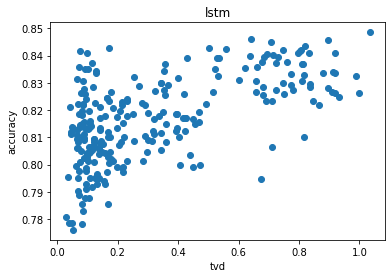

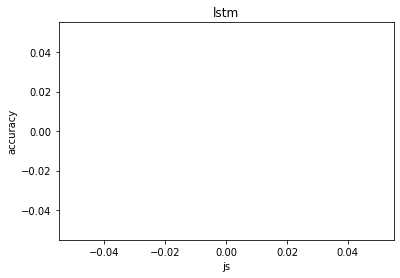

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


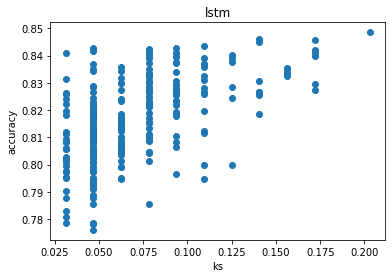

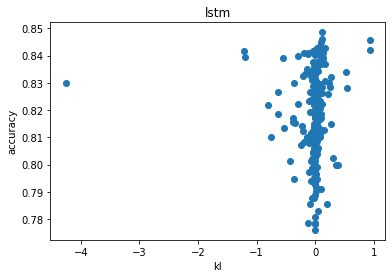

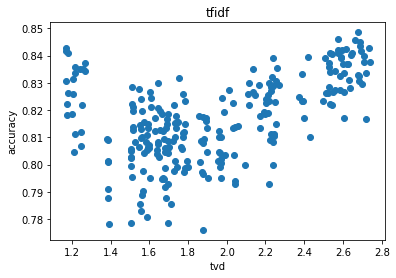

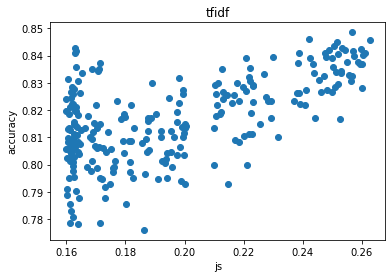

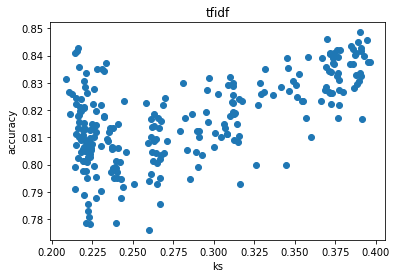

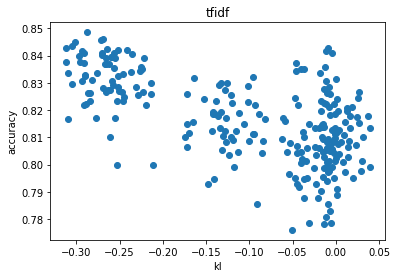

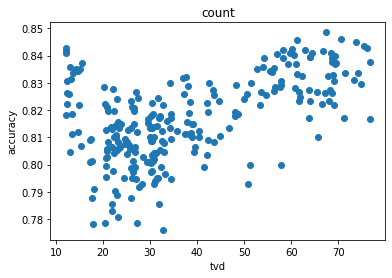

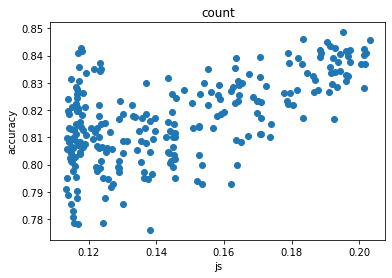

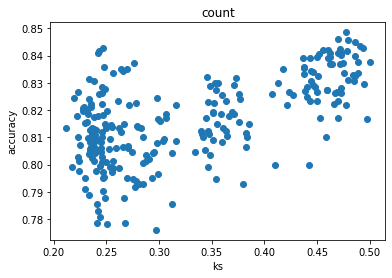

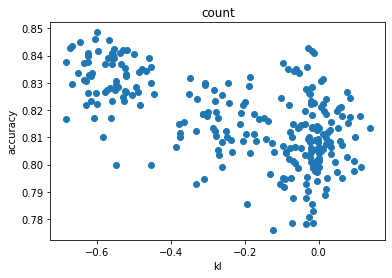

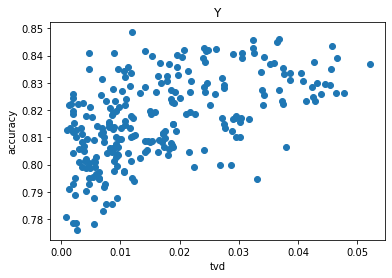

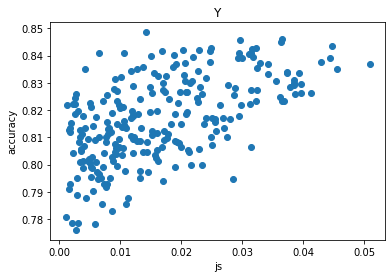

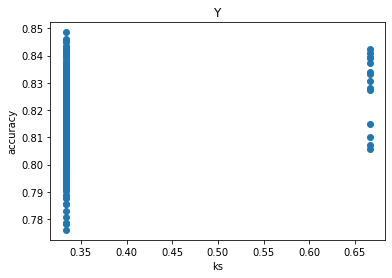

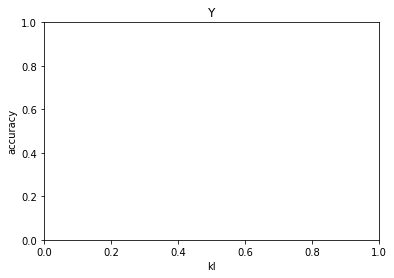

In [14]:
df_acc_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('accuracy', data_type, dis_metric)
    except:
        corr = np.nan
    df_acc_corr.loc[data_type][dis_metric] = corr

In [15]:
df_acc_corr
ur_style_2lstm_acc_1 = (df_acc_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_2lstm_acc_1

,tvd,js,ks,kl
lstm,60.055%,0.000%,54.985%,0.000%
tfidf,48.943%,60.331%,59.589%,-60.655%
count,54.131%,59.531%,60.342%,-59.546%
prob,0.000%,0.000%,0.000%,0.000%
Y,54.003%,57.415%,17.621%,0.000%


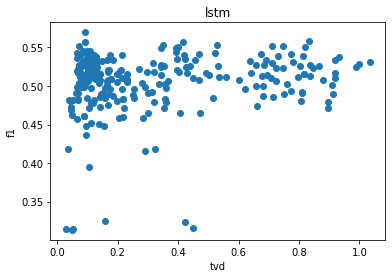

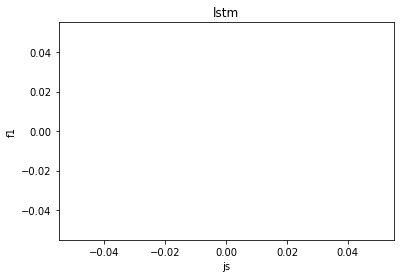

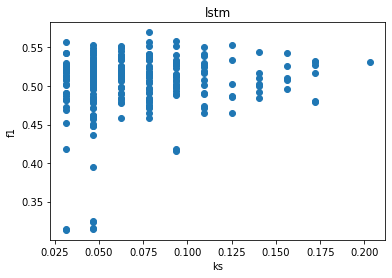

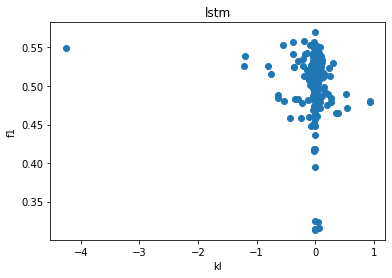

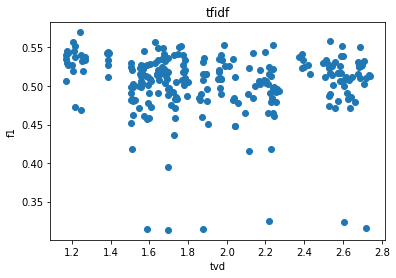

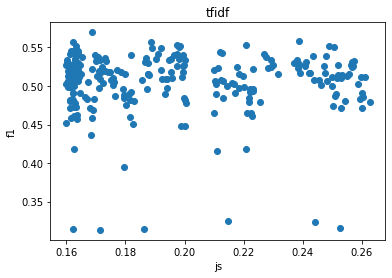

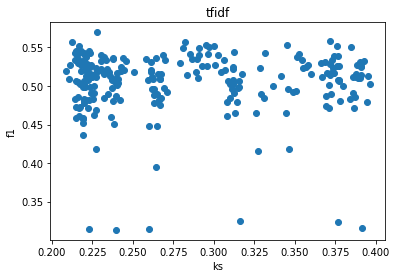

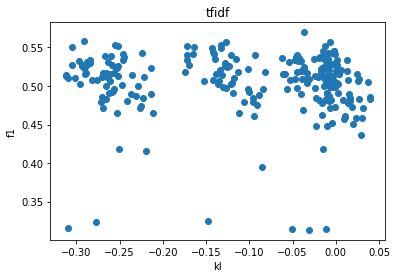

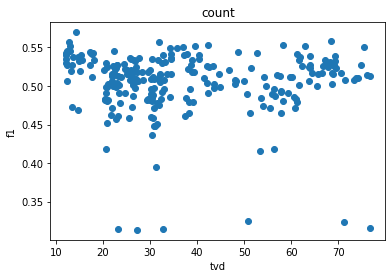

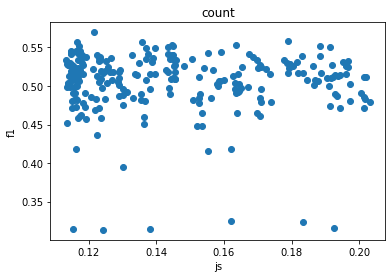

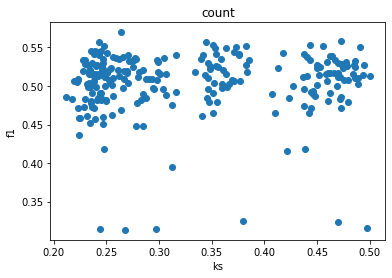

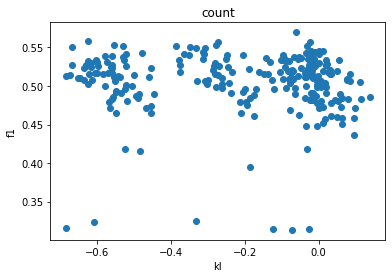

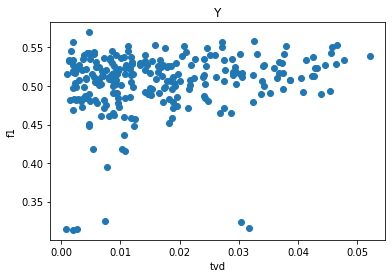

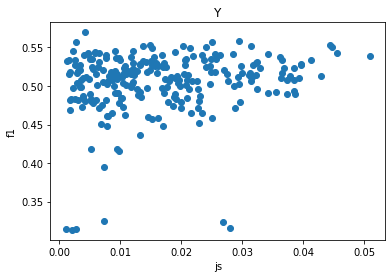

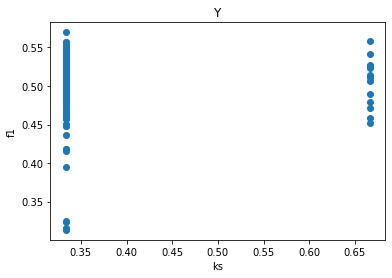

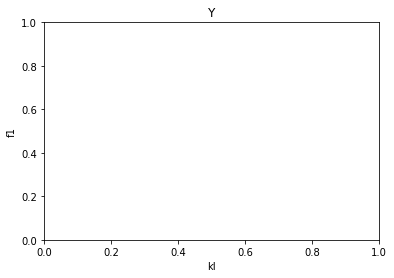

In [16]:
df_f1_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('f1', data_type, dis_metric)
    except:
        corr = np.nan
    df_f1_corr.loc[data_type][dis_metric] = corr

In [17]:
ur_style_2lstm_f1_1 = (df_f1_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_2lstm_f1_1

,tvd,js,ks,kl
lstm,15.577%,0.000%,13.689%,0.000%
tfidf,-9.743%,-2.118%,0.594%,-5.713%
count,-3.909%,-3.689%,3.508%,-5.977%
prob,0.000%,0.000%,0.000%,0.000%
Y,17.145%,17.011%,0.102%,0.000%


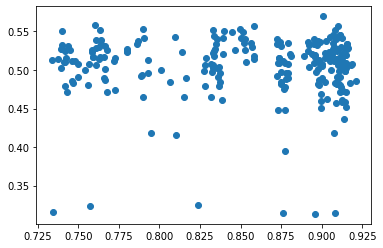

-0.013066921503323017

In [18]:
search_correlation_old(df_perc_no_zero, df_f1)

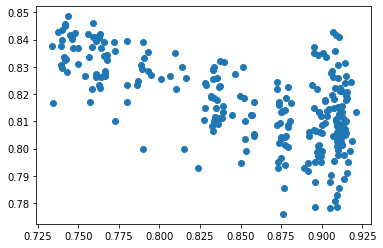

-0.6200976294716167

In [19]:
search_correlation_old(df_perc_no_zero, df_accuracy)

### Эксперимент 2

In [3]:
df_acc_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('accuracy', data_type, dis_metric)
    except:
        corr = np.nan
    df_acc_corr.loc[data_type][dis_metric] = corr

In [110]:
ur_style = (df_acc_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style

,tvd,js,ks,kl
lstm,55.376%,0.000%,43.946%,0.000%
tfidf,41.562%,53.747%,56.528%,-61.062%
count,50.854%,51.943%,58.957%,-60.275%
prob,0.000%,18.324%,11.272%,-3.277%
Y,49.676%,52.797%,14.932%,0.000%


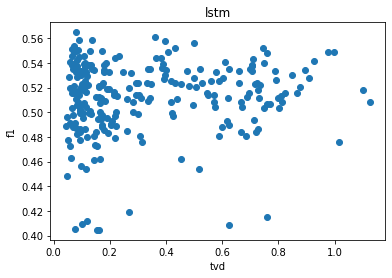

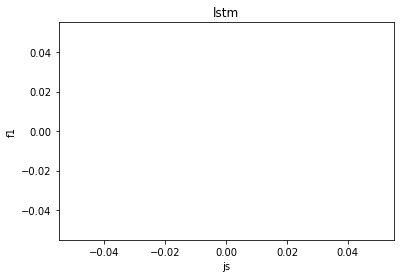

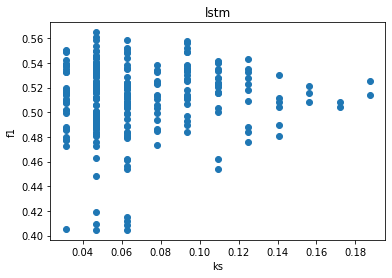

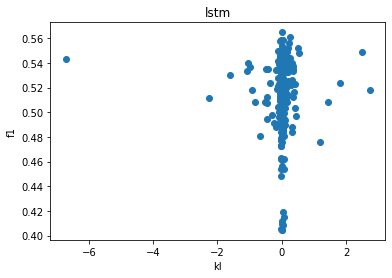

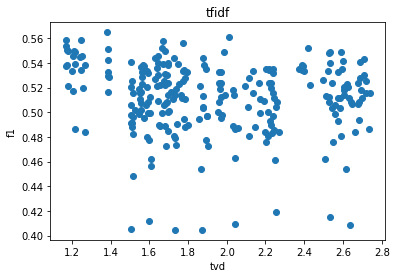

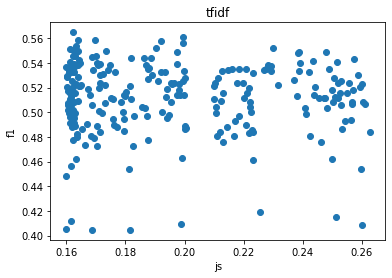

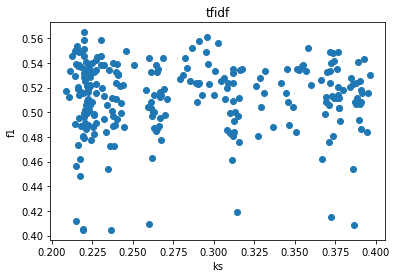

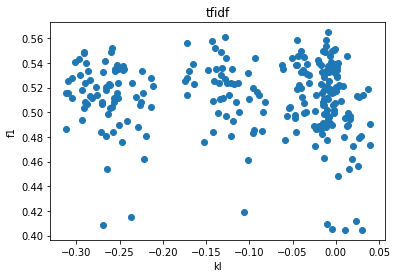

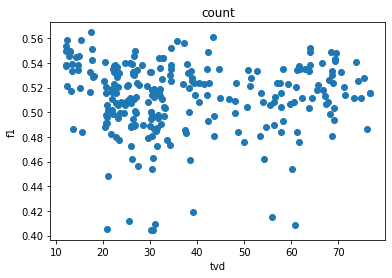

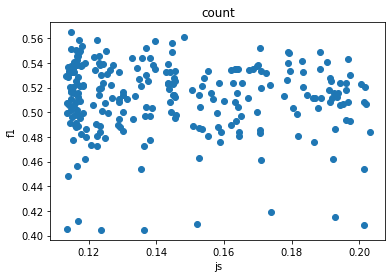

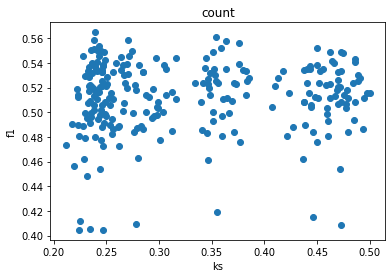

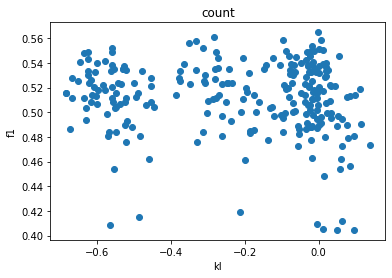

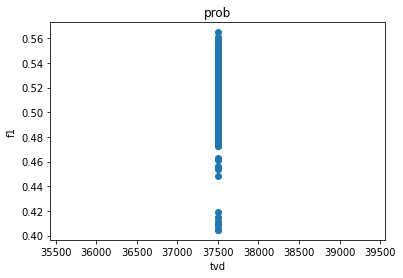

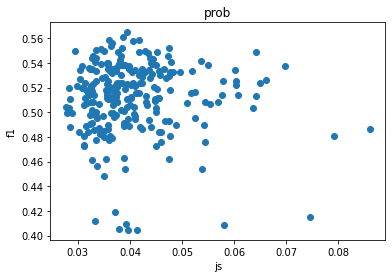

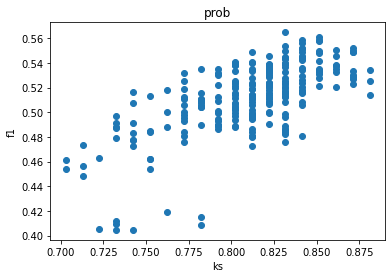

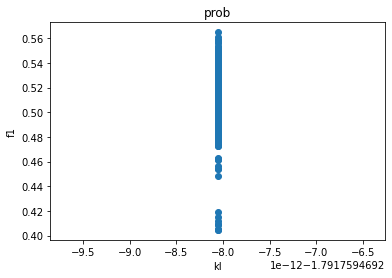

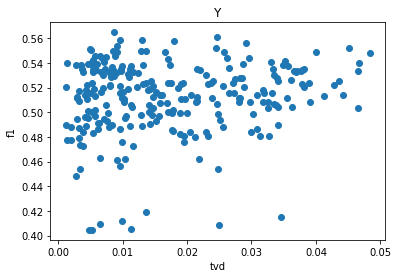

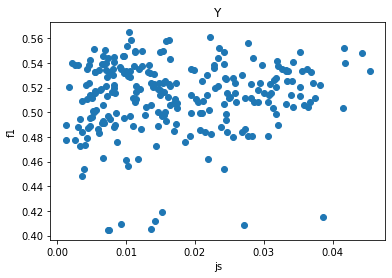

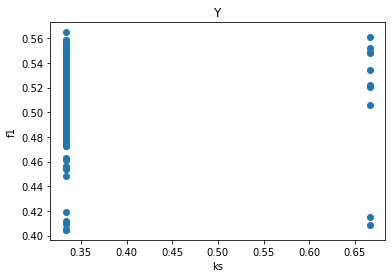

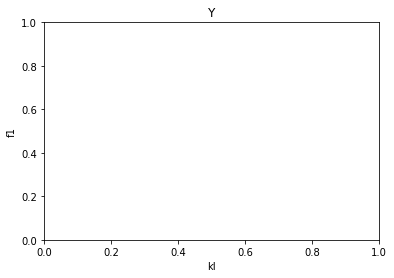

In [111]:
df_f1_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('f1', data_type, dis_metric)
    except:
        corr = np.nan
    df_f1_corr.loc[data_type][dis_metric] = corr

In [112]:
ur_style = (df_f1_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style

,tvd,js,ks,kl
lstm,9.717%,0.000%,5.646%,0.000%
tfidf,-13.495%,-5.037%,1.109%,-10.205%
count,-2.620%,-7.698%,6.548%,-11.607%
prob,0.000%,-3.348%,67.490%,-6.668%
Y,14.187%,10.389%,0.421%,0.000%


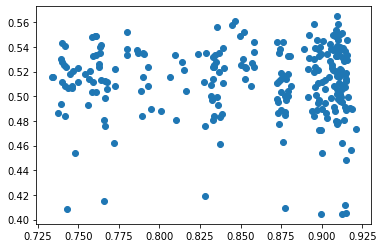

-0.022943385941320376

In [113]:
search_correlation_old(df_perc_no_zero, df_f1)

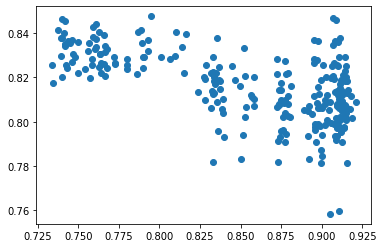

-0.5843192780240594

In [114]:
search_correlation_old(df_perc_no_zero, df_accuracy)

### Эксперимент 3

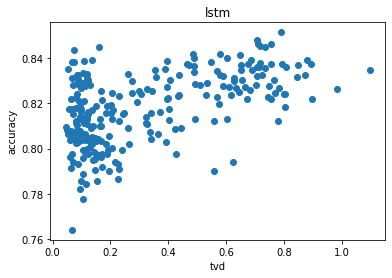

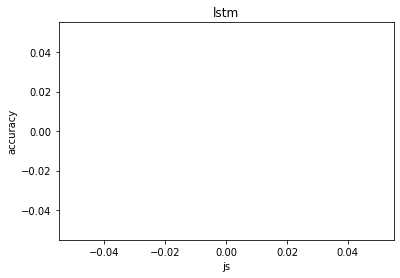

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


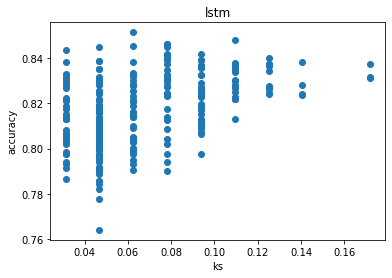

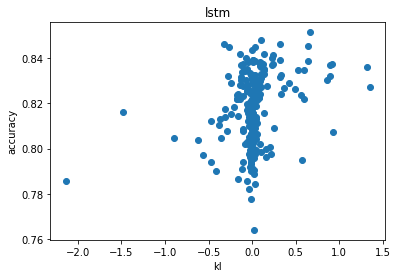

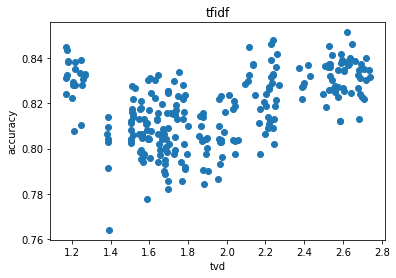

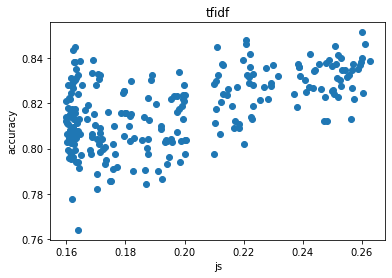

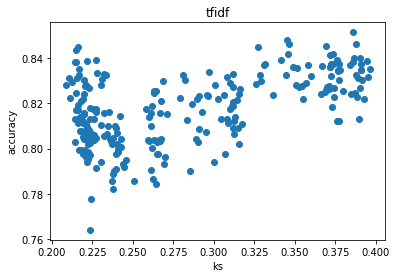

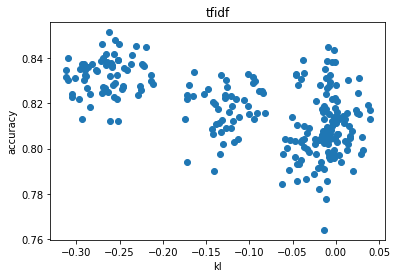

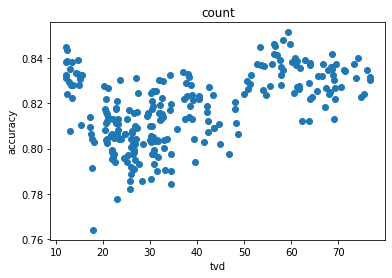

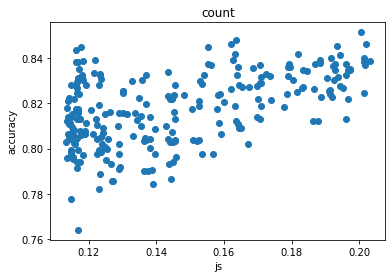

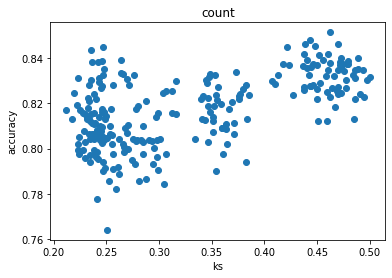

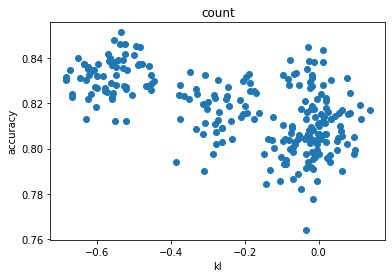

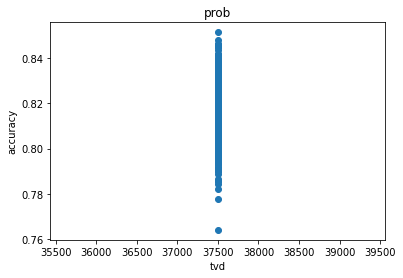

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


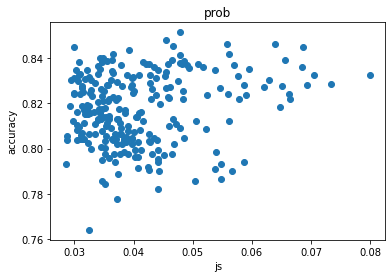

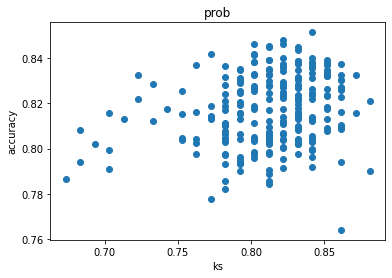

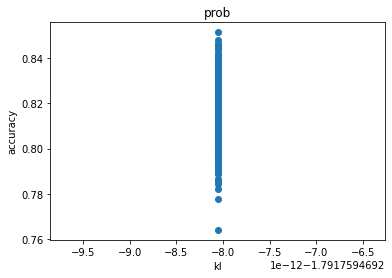

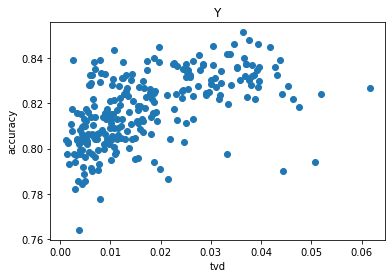

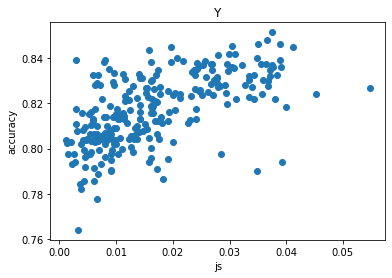

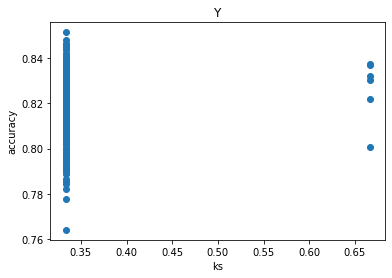

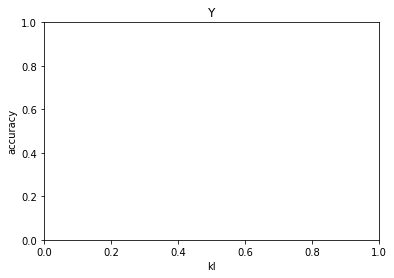

In [45]:
df_acc_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('accuracy', data_type, dis_metric)
    except:
        corr = np.nan
    df_acc_corr.loc[data_type][dis_metric] = corr

In [46]:
df_acc_corr
ur_style_2lstm_acc_3 = (df_acc_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_2lstm_acc_3

,tvd,js,ks,kl
lstm,55.343%,0.000%,45.881%,0.000%
tfidf,39.197%,53.207%,54.770%,-59.207%
count,48.626%,51.904%,57.786%,-58.416%
prob,0.000%,19.961%,22.136%,0.884%
Y,54.383%,60.071%,9.225%,0.000%


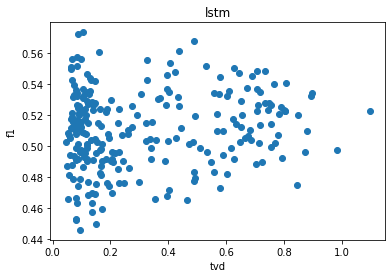

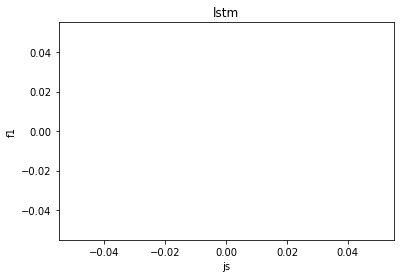

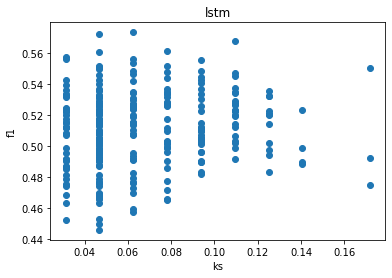

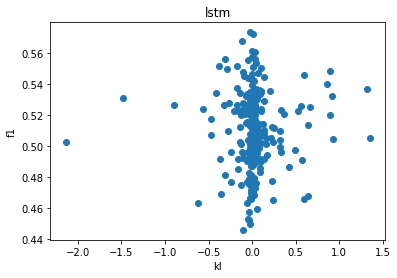

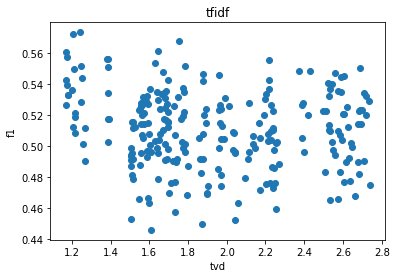

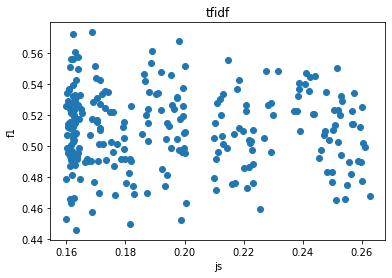

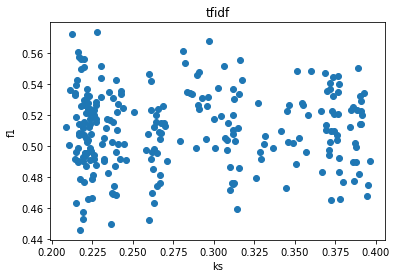

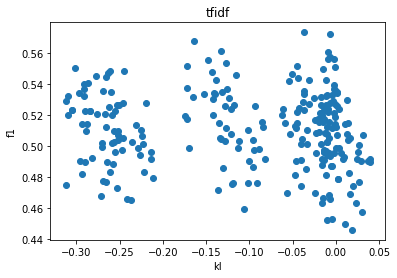

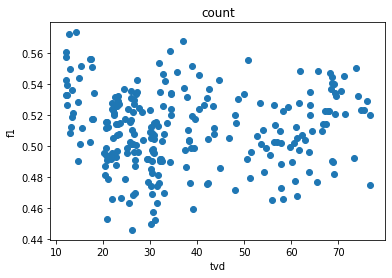

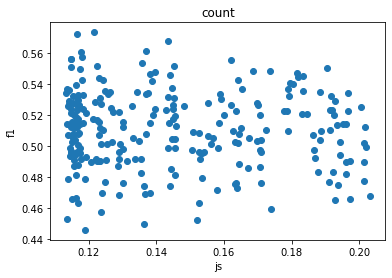

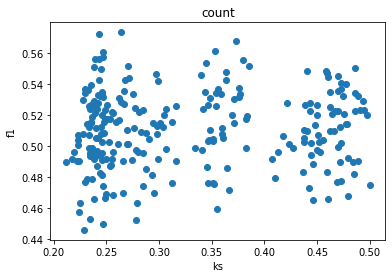

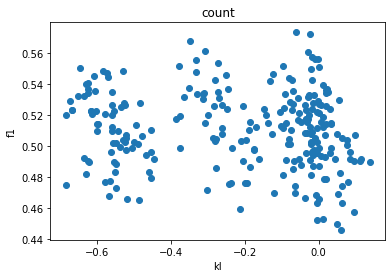

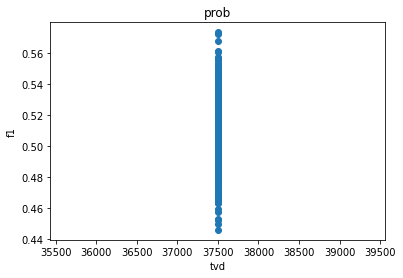

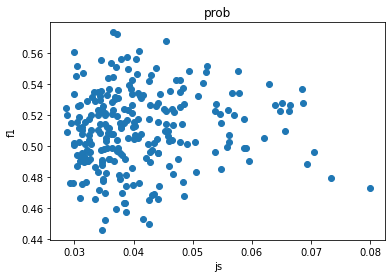

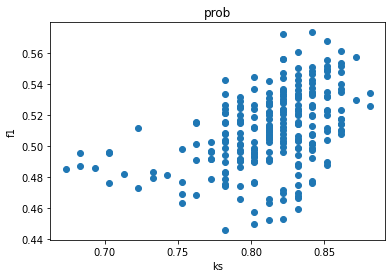

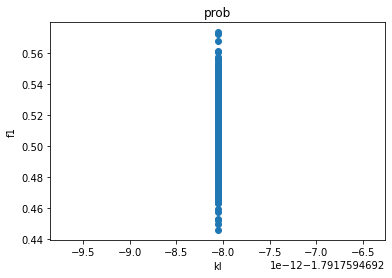

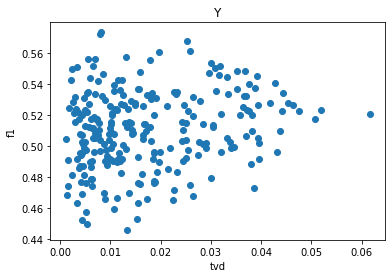

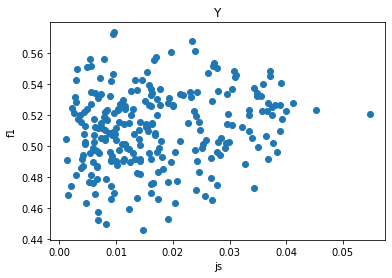

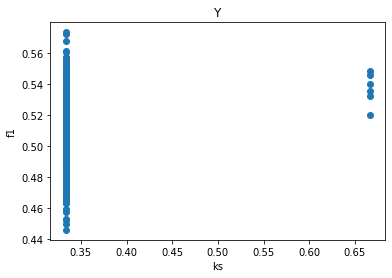

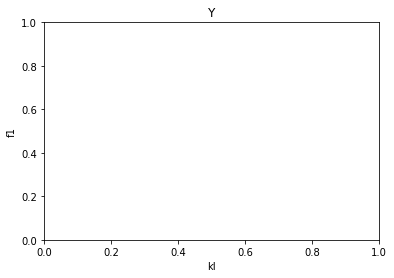

In [47]:
df_f1_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('f1', data_type, dis_metric)
    except:
        corr = np.nan
    df_f1_corr.loc[data_type][dis_metric] = corr

In [48]:
ur_style_2lstm_f1_3 = (df_f1_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_2lstm_f1_3

,tvd,js,ks,kl
lstm,13.668%,0.000%,12.504%,0.000%
tfidf,-13.533%,-3.951%,1.712%,-10.852%
count,-1.283%,-6.452%,7.524%,-12.607%
prob,0.000%,7.186%,44.257%,20.318%
Y,19.074%,17.436%,16.589%,0.000%


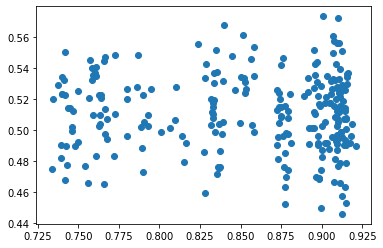

-0.034476991120637825

In [49]:
search_correlation_old(df_perc_no_zero, df_f1)

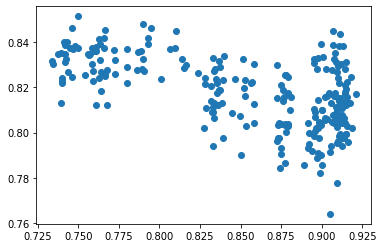

-0.5730022540308919

In [50]:
search_correlation_old(df_perc_no_zero, df_accuracy)

## 1 LSTM 1 Dense

### Эксперимент 1

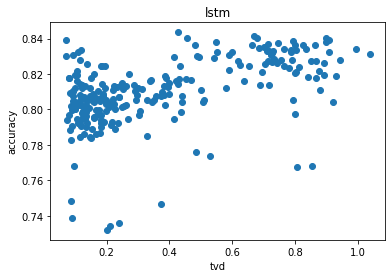

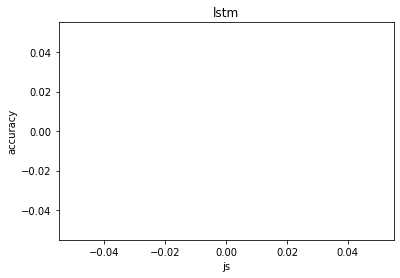

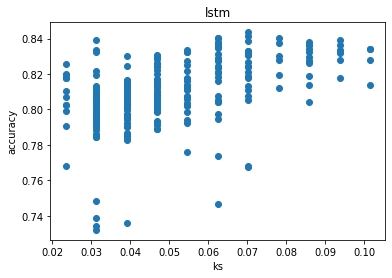

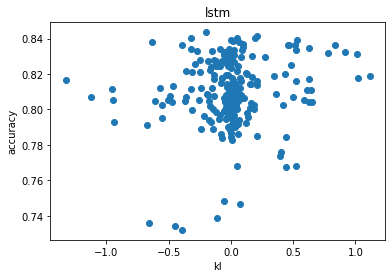

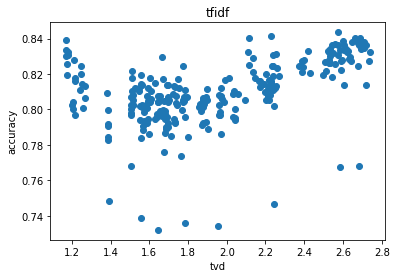

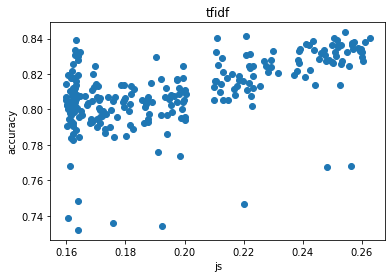

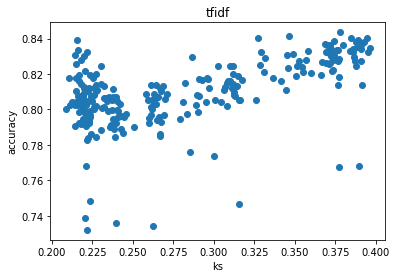

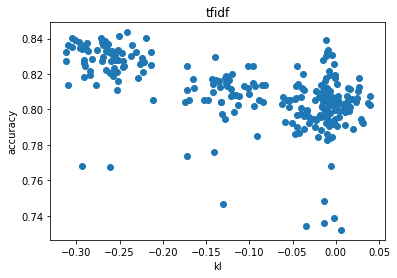

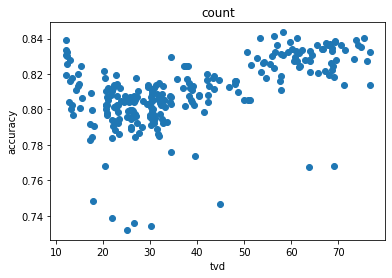

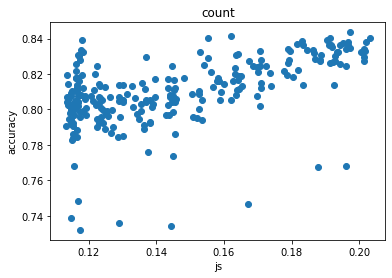

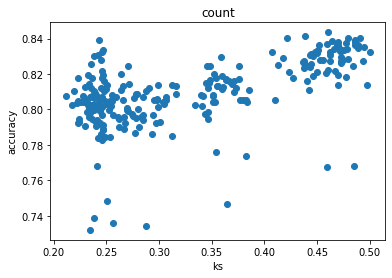

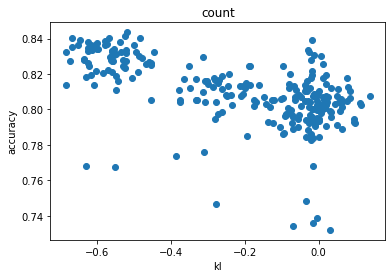

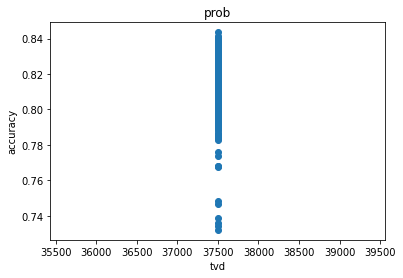

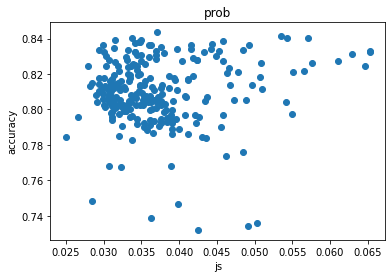

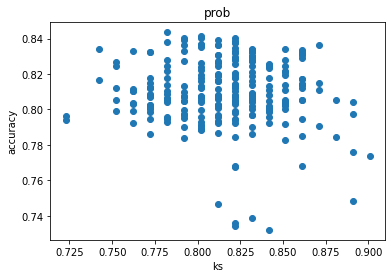

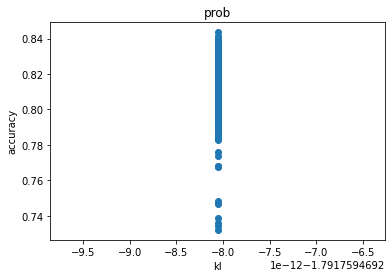

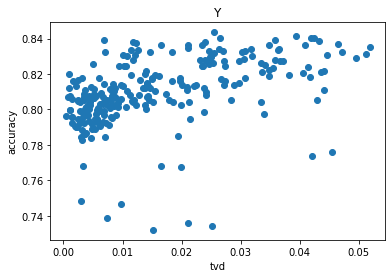

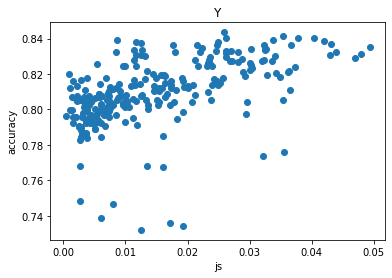

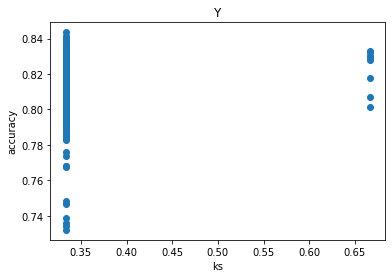

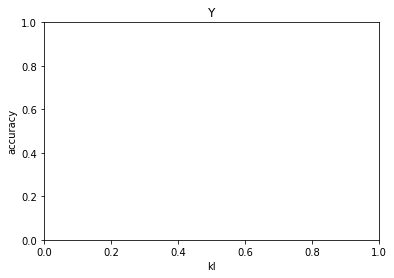

In [30]:
df_acc_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('accuracy', data_type, dis_metric)
    except:
        corr = np.nan
    df_acc_corr.loc[data_type][dis_metric] = corr

In [31]:
df_acc_corr
ur_style_1lstm_1dense_acc_1 = (df_acc_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_1lstm_1dense_acc_1

,tvd,js,ks,kl
lstm,50.449%,0.000%,48.282%,0.000%
tfidf,45.362%,54.191%,55.291%,-56.953%
count,51.543%,53.205%,56.309%,-56.105%
prob,0.000%,9.939%,-8.246%,12.327%
Y,45.808%,52.444%,13.691%,0.000%


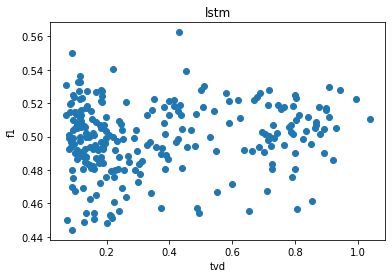

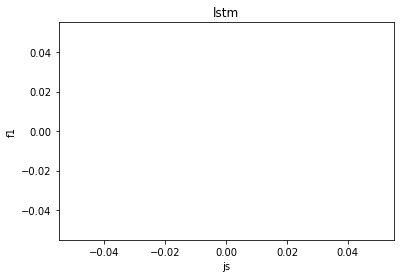

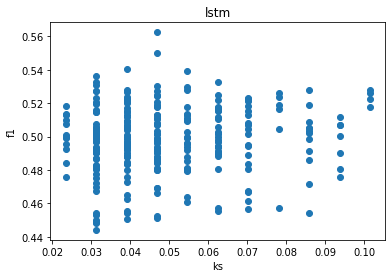

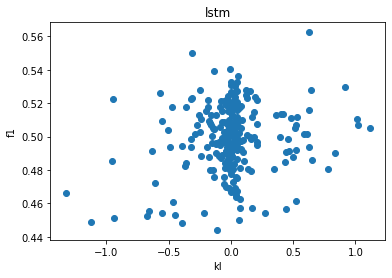

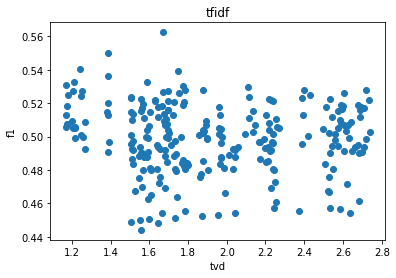

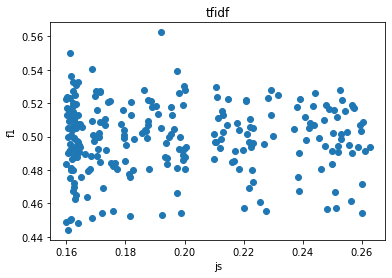

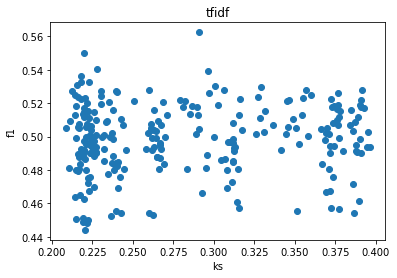

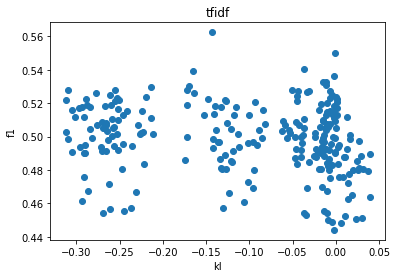

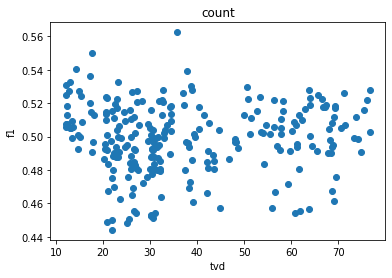

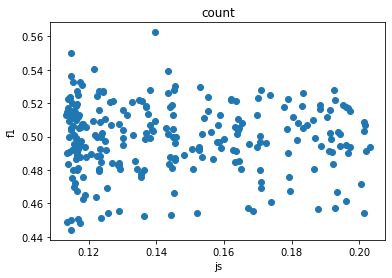

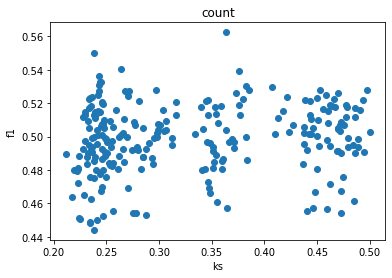

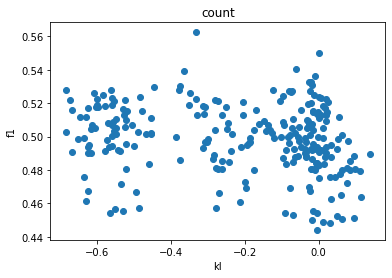

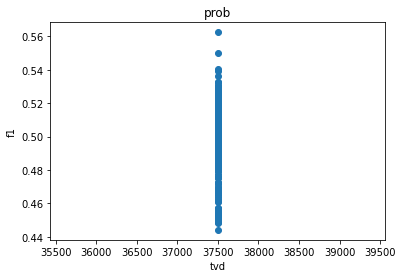

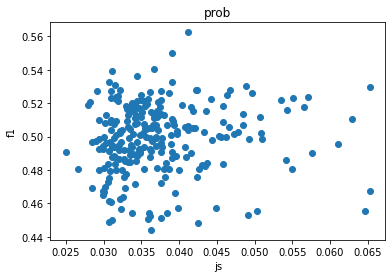

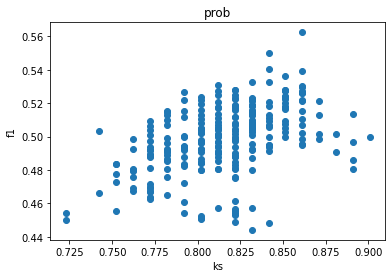

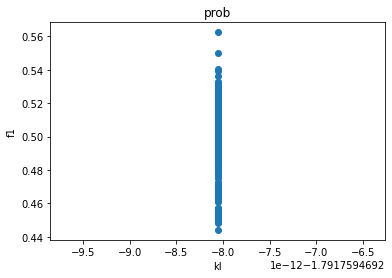

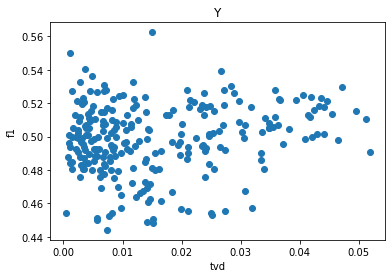

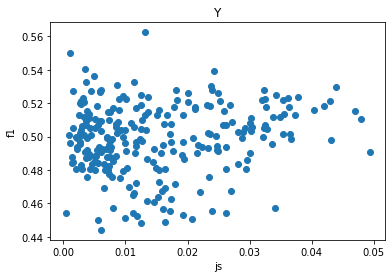

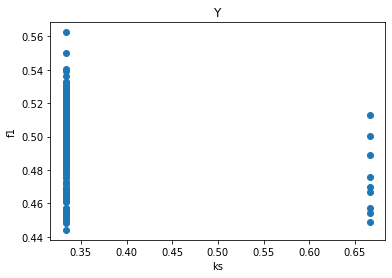

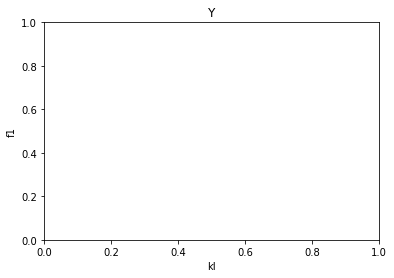

In [32]:
df_f1_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('f1', data_type, dis_metric)
    except:
        corr = np.nan
    df_f1_corr.loc[data_type][dis_metric] = corr

In [33]:
ur_style_1lstm_1dense_f1_1 = (df_f1_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_1lstm_1dense_f1_1

,tvd,js,ks,kl
lstm,14.186%,0.000%,9.657%,0.000%
tfidf,-8.678%,1.450%,7.822%,-17.155%
count,3.400%,-1.283%,13.876%,-18.578%
prob,0.000%,7.607%,44.699%,14.461%
Y,16.761%,12.921%,-21.783%,0.000%


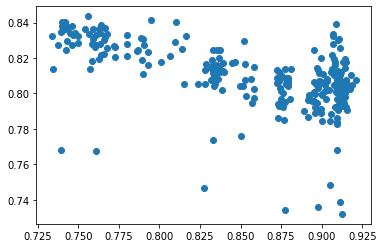

-0.5675664551459229

In [34]:
search_correlation_old(df_perc_no_zero, df_accuracy)

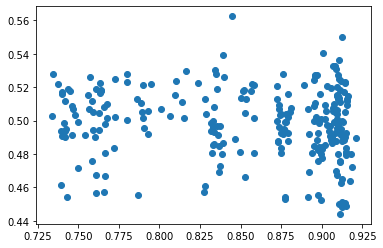

-0.09108723470085409

In [35]:
search_correlation_old(df_perc_no_zero, df_f1)

### Эксперимент 2

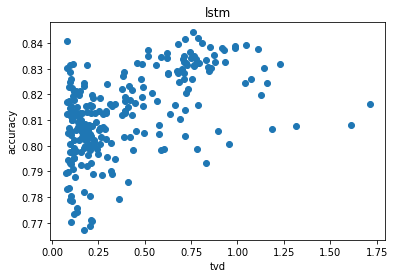

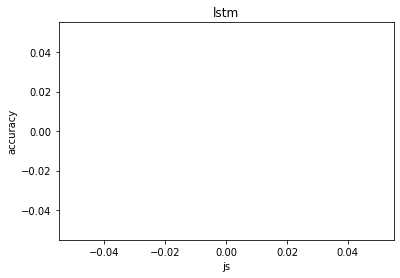

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


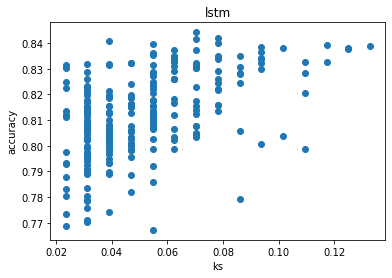

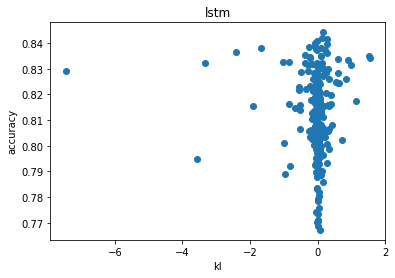

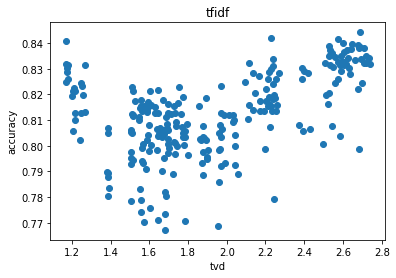

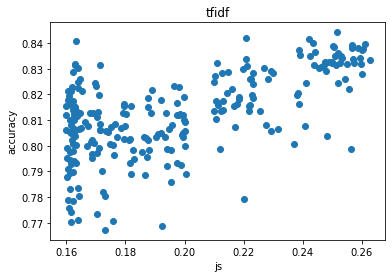

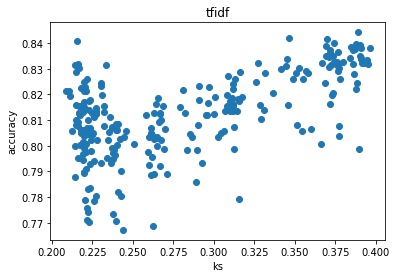

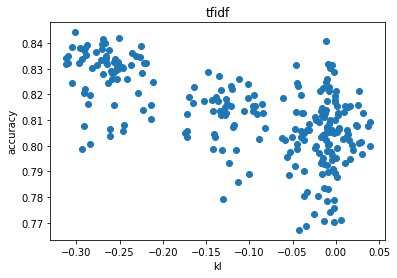

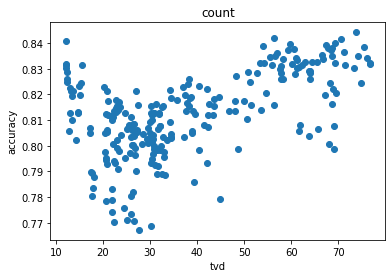

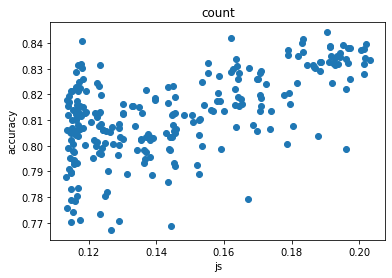

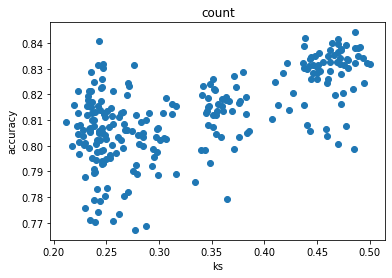

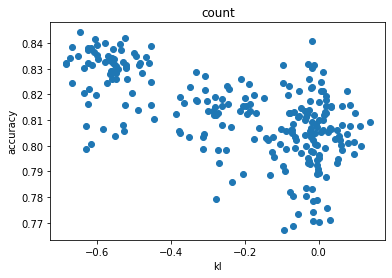

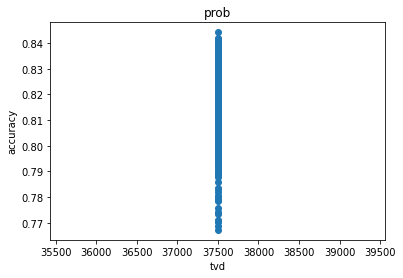

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


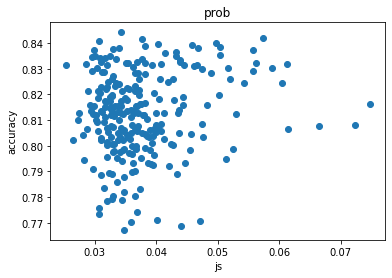

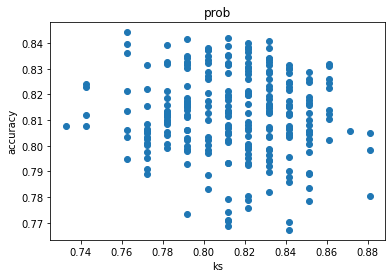

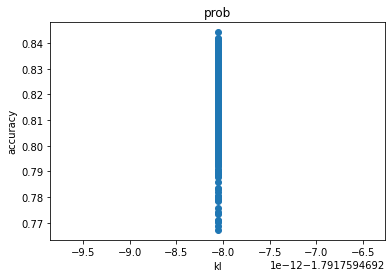

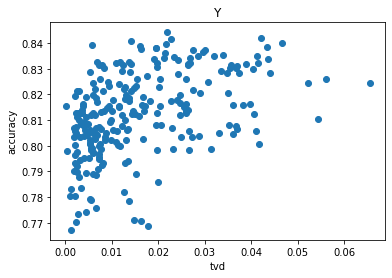

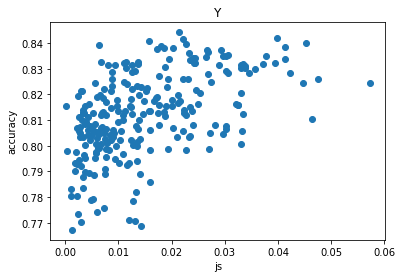

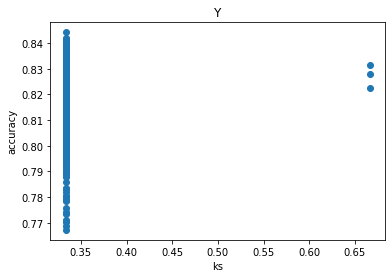

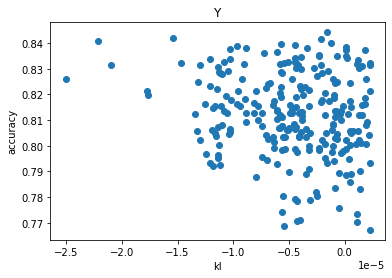

In [43]:
df_acc_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('accuracy', data_type, dis_metric)
    except:
        corr = np.nan
    df_acc_corr.loc[data_type][dis_metric] = corr

In [44]:
df_acc_corr
ur_style_1lstm_1dense_acc_2 = (df_acc_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_1lstm_1dense_acc_2

,tvd,js,ks,kl
lstm,50.672%,0.000%,50.562%,0.000%
tfidf,48.718%,59.991%,59.966%,-61.394%
count,54.915%,59.125%,61.199%,-60.695%
prob,0.000%,14.849%,-7.120%,11.801%
Y,45.478%,51.540%,10.160%,-17.969%


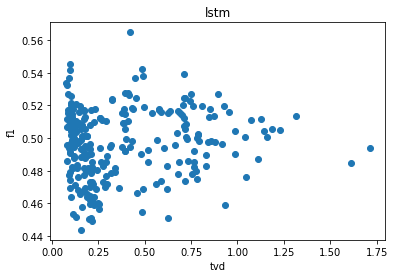

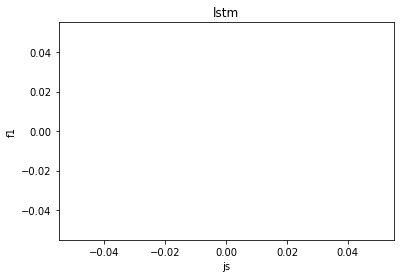

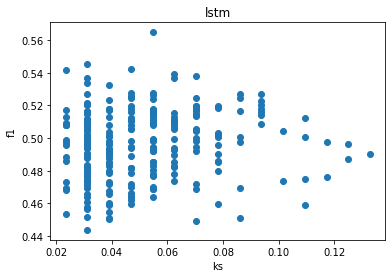

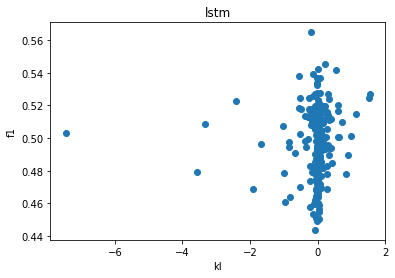

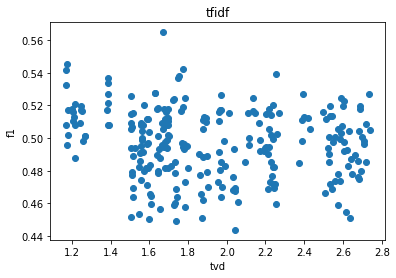

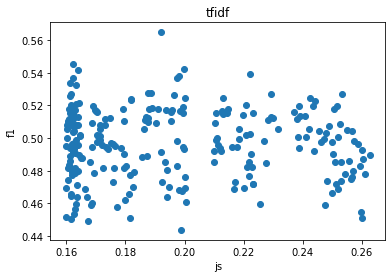

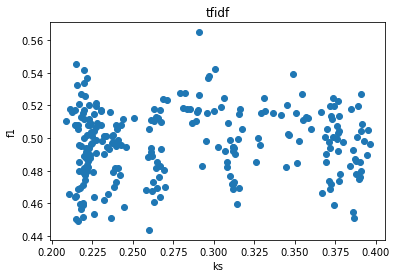

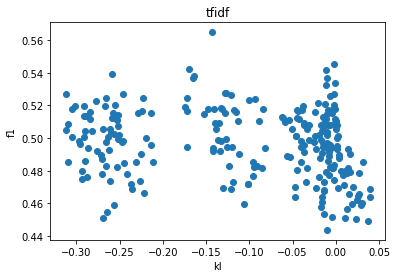

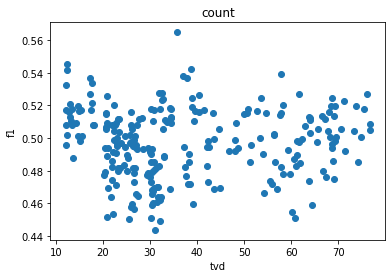

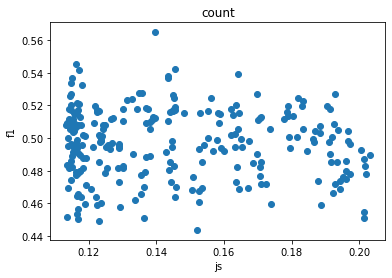

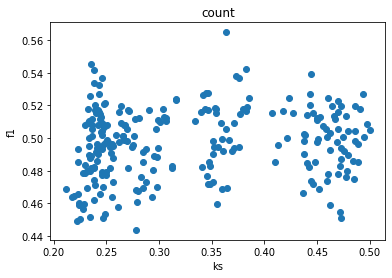

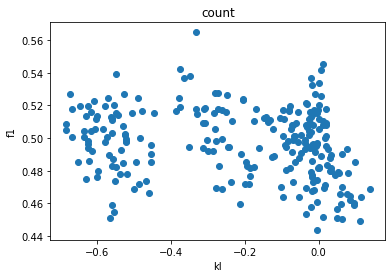

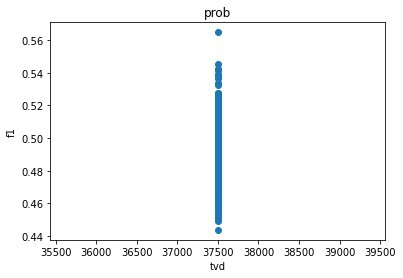

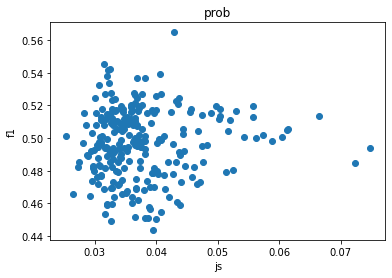

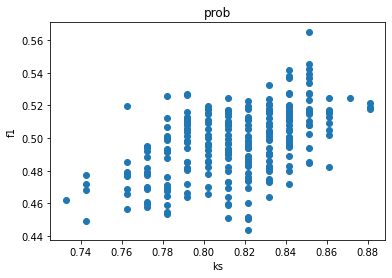

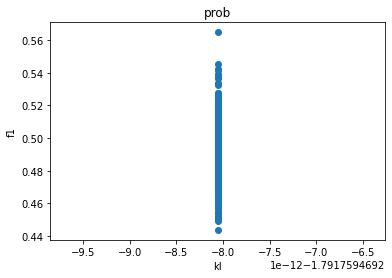

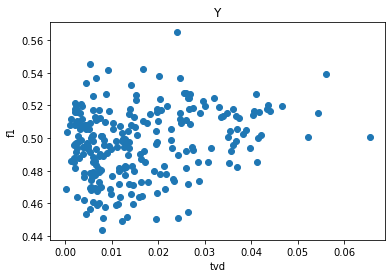

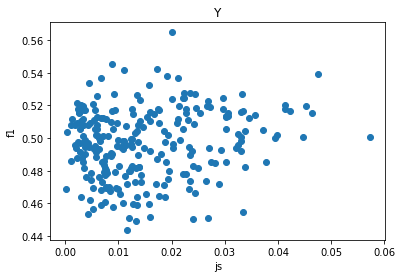

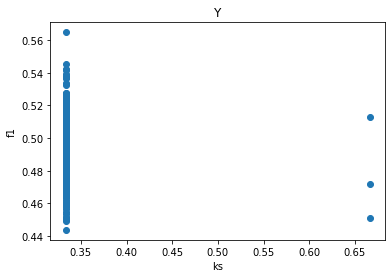

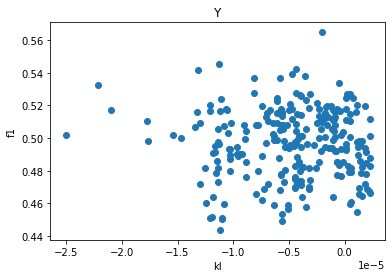

In [45]:
df_f1_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('f1', data_type, dis_metric)
    except:
        corr = np.nan
    df_f1_corr.loc[data_type][dis_metric] = corr

In [46]:
ur_style_1lstm_1dense_f1_2 = (df_f1_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_1lstm_1dense_f1_2

,tvd,js,ks,kl
lstm,11.355%,0.000%,8.398%,0.000%
tfidf,-14.565%,-3.335%,6.613%,-19.715%
count,2.137%,-7.222%,14.720%,-21.861%
prob,0.000%,5.186%,48.333%,7.057%
Y,22.347%,15.484%,-9.410%,-2.310%


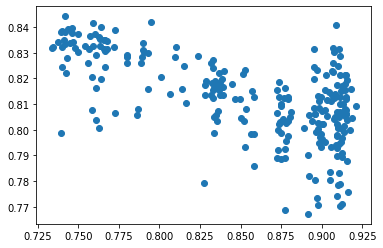

-0.6226216844360986

In [47]:
search_correlation_old(df_perc_no_zero, df_accuracy)

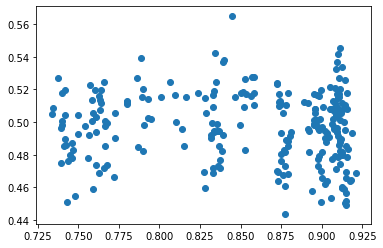

-0.07630280844970351

In [48]:
search_correlation_old(df_perc_no_zero, df_f1)

### Эксперимент 3

In [7]:
df_acc_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('accuracy', data_type, dis_metric)
    except:
        corr = np.nan
    df_acc_corr.loc[data_type][dis_metric] = corr

In [8]:
df_acc_corr
ur_style_1lstm_1dense_acc_3 = (df_acc_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_1lstm_1dense_acc_3

,tvd,js,ks,kl
lstm,0.000%,0.000%,0.000%,0.000%
tfidf,0.000%,0.000%,0.000%,0.000%
count,0.000%,0.000%,0.000%,0.000%
prob,0.000%,0.000%,0.000%,0.000%
Y,0.000%,0.000%,0.000%,0.000%


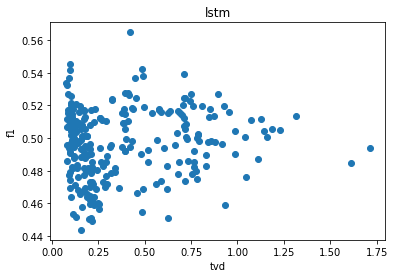

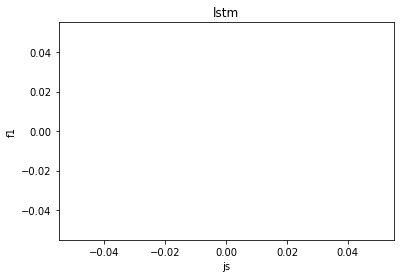

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


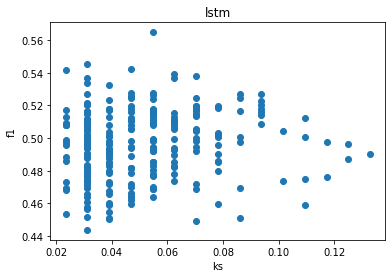

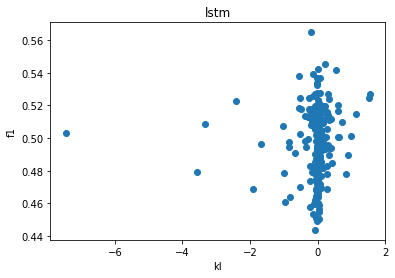

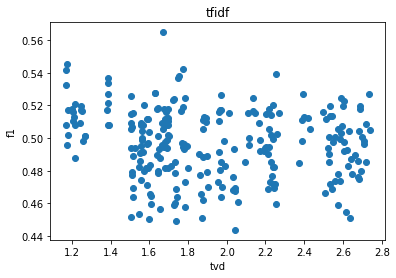

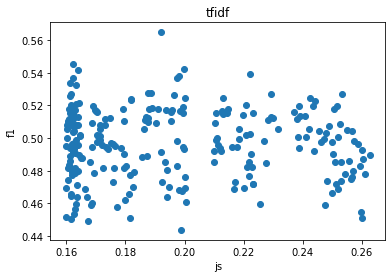

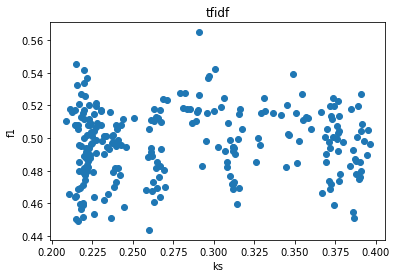

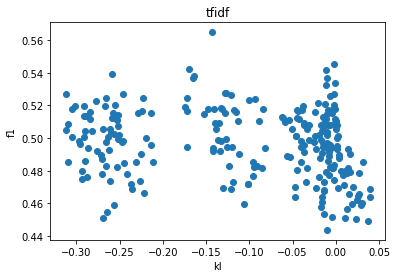

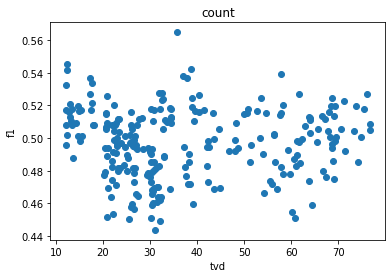

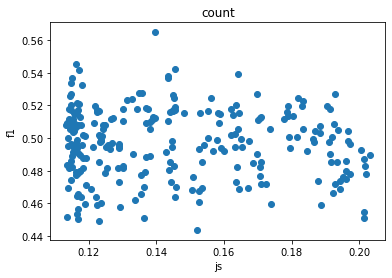

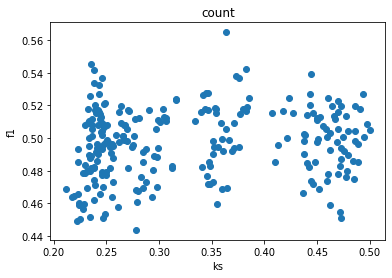

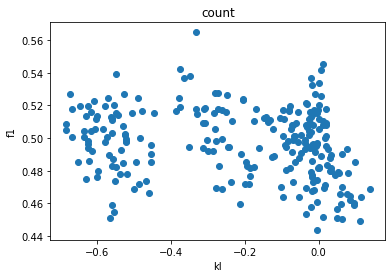

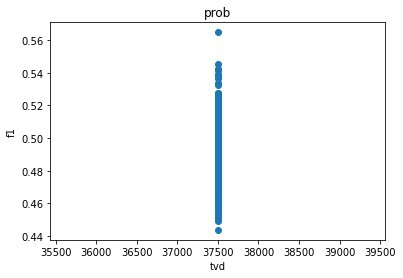

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


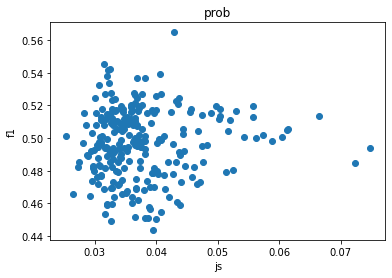

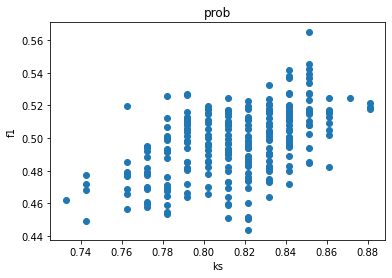

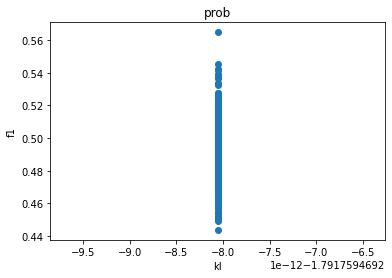

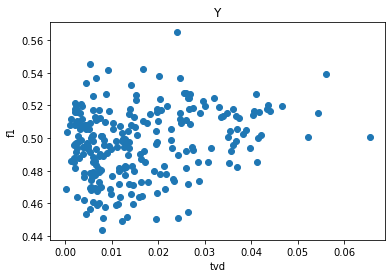

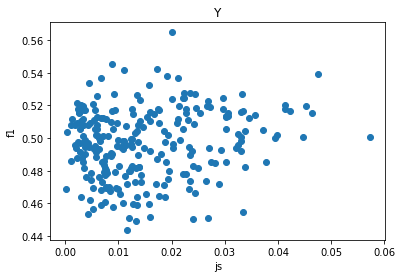

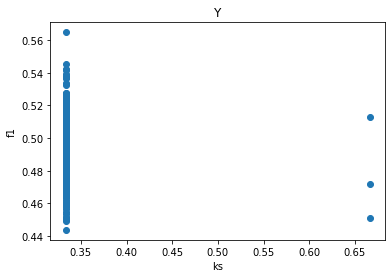

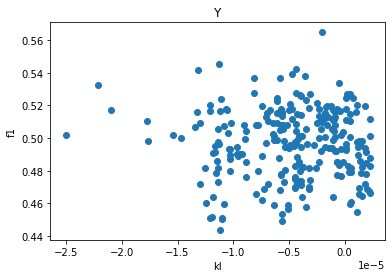

In [50]:
df_f1_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('f1', data_type, dis_metric)
    except:
        corr = np.nan
    df_f1_corr.loc[data_type][dis_metric] = corr

In [52]:
ur_style_1lstm_1dense_f1_3 = (df_f1_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_1lstm_1dense_f1_3

,tvd,js,ks,kl
lstm,11.355%,0.000%,8.398%,0.000%
tfidf,-14.565%,-3.335%,6.613%,-19.715%
count,2.137%,-7.222%,14.720%,-21.861%
prob,0.000%,5.186%,48.333%,7.057%
Y,22.347%,15.484%,-9.410%,-2.310%


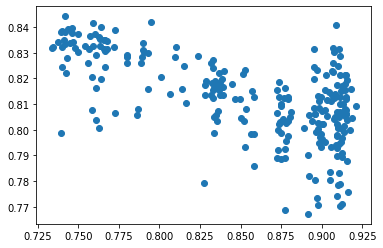

-0.6226216844360986

In [53]:
search_correlation_old(df_perc_no_zero, df_accuracy)

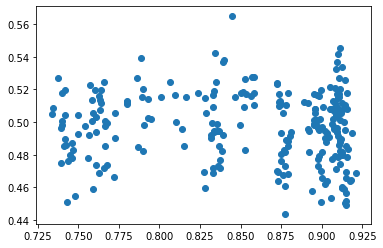

-0.07630280844970351

In [54]:
search_correlation_old(df_perc_no_zero, df_f1)